<a href="https://colab.research.google.com/github/diana-legrand/pet_projects/blob/main/hockey_project/EU__Diana_Legrand_Hockey_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**<font size = 6> Pet-Project.  Network Analysis of Hockey Players </font>**

📌 **Project Overview**
This project delves into the interconnectedness of players within the Kontinental Hockey League (KHL) by introducing the "Lemtyugov Number"—a concept inspired by the Erdős and Bacon numbers. It quantifies how closely a given player is connected to Nikolay Lemtyugov through shared team associations.

🎯 **Objectives**

*   Data Collection: Gather comprehensive data on KHL players and their team histories.
*    Graph Construction: Build a network graph where nodes represent players and edges denote shared team memberships.
*   Lemtyugov Number Calculation: Determine the minimum number of connections separating each player from Nikolay Lemtyugov.
*   Visualization: Create visual representations of the player network to identify clusters and connection patterns.

In [1]:
#!pip install pingouin

In [272]:
import pandas as pd
import numpy as np
import math
import random
import re
import requests
import time

from google.colab import drive
from google.colab import files

from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

import networkx as nx
import collections
from queue import Queue

import scipy.stats as stats
from scipy.stats import ttest_ind
import pingouin as pg
import statsmodels.api as sm

import os
import cProfile
import threading
import multiprocessing

import warnings
#warnings.filterwarnings("ignore", category=pd.core.common.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler


pd.set_option('display.float_format', '{:,.2f}'.format) #настройки pandas для отображения чисел без лишних запятых
pd.set_option("max_colwidth", 200) #настройки pandas для отображения строк полностью

# Data Collection and Processing

Four datasets were collected and curated for this project, all sourced from *eliteprospects.com*:

* players_data.csv – Contains a complete list of players who have played for KHL teams since the 2008–2009 season.

* transfers.csv – Tracks player transfers across various leagues, starting from the earliest recorded transfer on December 14, 2007.

* players_personal_data.csv – Includes personal details such as birth year, nationality, height, weight, and handedness.

* player_stats.csv – Provides player performance metrics and season-by-season statistics.

The datasets were cleaned, merged, and analyzed according to the project’s objectives — enabling graph-based modeling of player connections and deeper insights into career mobility, relational proximity, and league structure.

For reproducibility and ease of access, a cleaned and consolidated dataset was made available via a public Google Sheets link.

In [271]:
players_data = pd.read_csv('https://raw.githubusercontent.com/diana-legrand/pet_projects/refs/heads/main/hockey_project/players_data.csv')

In [273]:
players_data.head()

Team     Season                Player  Player_number  \
0  Salavat Yulaev Ufa  2008-2009          Sergei Belov             31   
1  Salavat Yulaev Ufa  2008-2009       Rafael Khakimov             31   
2  Salavat Yulaev Ufa  2008-2009         Vadim Tarasov              1   
3  Salavat Yulaev Ufa  2008-2009  Alexander Yeryomenko             30   
4  Salavat Yulaev Ufa  2008-2009       Miroslav Blatak             23   

  Position Captain  Born            Birthplace   Age  Height  Weight Stick  \
0        G     NaN  1982   St. Petersburg, RUS 40.00     180      78     L   
1        G     NaN  1990              Ufa, RUS 33.00     180      78     L   
2        G     NaN  1976  Ust-Kamenogorsk, KAZ 46.00     183      84     L   
3        G     NaN  1980           Moskva, RUS 43.00     180      78     L   
4        D     NaN  1982             Zlin, CZE 41.00     180      78     L   

                                                        Player_link  
0          https://www.eliteprospects.com/player/19555/sergei-belov  
1       https://www.eliteprospects.com/player/47547/rafael-khakimov  
2         https://www.eliteprospects.com/player/11990/vadim-tarasov  
3  https://www.eliteprospects.com/player/12286/alexander-yeryomenko  
4        https://www.eliteprospects.com/player/8421/miroslav-blatak

Датасет с игроками - это список всех игроков, которые играли в Лиге КХЛ за всю историю сущестования лиги с 2008 года.

Описание данных

* Team - команда
* Season - сезон
* Player - Имя игрока
* Player_number - игровой номер
* Position - игровое амплуа, возможные значения (сочетания через /):
  * G - голкипер
  * D - защитник
  * RW - правый вингер
  * LW - левый вингер
  * C - центр-форвард
  * F - форвард
  * W - вингер
* Captain - статус игрока:
  * C - капитан
  * A - ассистент
* Born - год рождения
* Birthplace - место рождения
* Age - возраст на момент парсинга, 5 jun 2023
* Height - рост в см
* Weight - вес в кг
* Stick - хват клюшки
* Player_link - ссылка на страницу игрока, уникальное поле

In [7]:
players_data.describe()

Player_number      Born       Age    Height    Weight
count      14,332.00 14,332.00 14,234.00 14,332.00 14,332.00
mean           42.58  1,988.93     33.55    184.25     89.03
std            29.25      6.50      6.51      5.55      7.71
min             1.00  1,958.00     17.00    167.00     61.00
25%            17.00  1,985.00     29.00    180.00     84.00
50%            36.00  1,989.00     33.00    184.00     89.00
75%            70.00  1,994.00     38.00    188.00     94.00
max            99.00  2,005.00     65.00    206.00    119.00

Номера игроков - от 1 до 99, родились с 1958 г. по 2005 г., соответственно возраст - от 17 до 65 лет (по состоянию на июнь 2023 г.), рост - от 167 до 206 см, вес - от 61 кг до 119 кг.

Проверим количество уникальных игроков:

In [8]:
players_data['Player_link'].nunique()

3599

## Внешний датасет с игроками

For reproducibility and ease of access, a cleaned and consolidated dataset was made available via a public Google Sheets link.

In [274]:
players = pd.read_csv(
    'https://docs.google.com/spreadsheets/d/e/2PACX-1vT3TtrPT83dPIbAEtp5tjhpHmllTxYjFhJ62lThCeI9yPMeYwMCHPq9J5uoAL-Zcx3HvxMlXEeEl8iT/pub?output=csv'
)

In [84]:
players.head()

player_link  \
0  https://en.khl.ru/players/16785/?idplayer=16785&PAGEN_1=1   
1  https://en.khl.ru/players/16785/?idplayer=16785&PAGEN_1=1   
2  https://en.khl.ru/players/17585/?idplayer=17585&PAGEN_1=1   
3  https://en.khl.ru/players/17585/?idplayer=17585&PAGEN_1=1   
4  https://en.khl.ru/players/17585/?idplayer=17585&PAGEN_1=1   

               player          team   start_date     end_date  
0  Juhamatti Aaltonen       Jokerit   4 Sep 2014   2 Mar 2016  
1  Juhamatti Aaltonen  Metallurg Mg   9 Sep 2010  22 Mar 2012  
2       Miro Aaltonen        Vityaz   2 Sep 2021  11 Jan 2022  
3       Miro Aaltonen           SKA  17 Dec 2019  27 Feb 2021  
4       Miro Aaltonen        Vityaz  27 Aug 2016   9 Dec 2019

In [85]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8179 entries, 0 to 8178
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   player_link  8179 non-null   object
 1   player       8179 non-null   object
 2   team         8179 non-null   object
 3   start_date   8179 non-null   object
 4   end_date     8179 non-null   object
dtypes: object(5)
memory usage: 319.6+ KB


### Предобработка

Приведем тип данных в столбцах start_date, end_date к нужному типу:

In [86]:
players['start_date'] = pd.to_datetime(players['start_date'], format='%d %b %Y')
players['end_date'] = pd.to_datetime(players['end_date'], format='%d %b %Y')

Получим id игрока:

In [87]:
players['player_id'] = players['player_link'].str.split('/').str[-2]

In [88]:
players = players.drop('player_link', axis=1)

In [89]:
players = players[['player', 'player_id', 'team', 'start_date', 'end_date']]

In [90]:
players.head()

player player_id          team start_date   end_date
0  Juhamatti Aaltonen     16785       Jokerit 2014-09-04 2016-03-02
1  Juhamatti Aaltonen     16785  Metallurg Mg 2010-09-09 2012-03-22
2       Miro Aaltonen     17585        Vityaz 2021-09-02 2022-01-11
3       Miro Aaltonen     17585           SKA 2019-12-17 2021-02-27
4       Miro Aaltonen     17585        Vityaz 2016-08-27 2019-12-09

In [91]:
!ls

sample_data


In [92]:
directory = '/content/drive/MyDrive'
os.makedirs(directory, exist_ok=True)

In [93]:
#players.to_csv('/content/drive/MyDrive/players.csv', index=False)
players.to_csv('/content/players.csv', index=False)

In [94]:
%pwd

'/content'

In [95]:
# Подключение к Google Drive
#drive.mount('/content/drive')

# Путь к файлу на Google Drive
#file_path = '/content/drive/MyDrive/players.csv'

# Сохранение датафрейма в CSV-файле
#players.to_csv(file_path, index=False)

# Скачивание файла на локальный компьютер
#files.download(file_path)

Посмотрим количество уникальных игроков и количество уникальных команд:

In [96]:
players['player_id'].nunique()

3720

In [97]:
players['team'].nunique()

38

Посмотрим, сколько уникальных игроков было в той или иной команде:

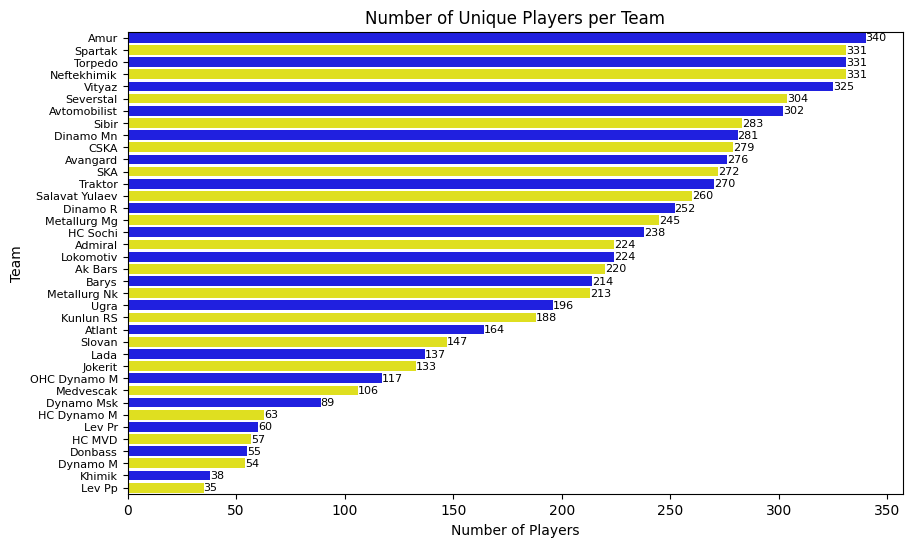

In [98]:
grouped_players = players.groupby('team')['player_id'].agg('nunique')
grouped_players = grouped_players.sort_values(ascending=False)
custom_palette = ['blue', 'yellow']

plt.figure(figsize=(10, 6))
sns.barplot(x=grouped_players.values, y=grouped_players.index, palette=custom_palette)

plt.xlabel('Number of Players')
plt.ylabel('Team')
plt.title('Number of Unique Players per Team')

plt.tick_params(axis='y', labelsize=8)

for index, value in enumerate(grouped_players.values):
    plt.text(value, index, str(value), va='center', fontsize=8)

plt.show()

Больше всего игроков было в команде Amur(340), меньше всего - в Lev Pp.

### Словарь player_id, player

In [99]:
players.head()

player player_id          team start_date   end_date
0  Juhamatti Aaltonen     16785       Jokerit 2014-09-04 2016-03-02
1  Juhamatti Aaltonen     16785  Metallurg Mg 2010-09-09 2012-03-22
2       Miro Aaltonen     17585        Vityaz 2021-09-02 2022-01-11
3       Miro Aaltonen     17585           SKA 2019-12-17 2021-02-27
4       Miro Aaltonen     17585        Vityaz 2016-08-27 2019-12-09

In [100]:
player_dict = players.set_index('player_id')['player'].to_dict()

In [101]:
def find_player_id_by_name(player_dict, player_name):
    """
    Функция находит player_id для имени игрока из словаря.

    Параметры:
        player_dict (dict): Название словаря.
        player_name (str): Имя игрока, id которого надо установить.

    Returns:
        int or None: Возращает id игрока или None
    """
    for player_id, name in player_dict.items():
        if name == player_name:
            return player_id
    return None

In [102]:
player_dict['13705']

'Nikolai Lemtyugov'

### ID Лемтюгова

In [103]:
find_player_id_by_name(player_dict, "Nikolai Lemtyugov")

'13705'

### Объединие датасета самого с собой для получения списка одноклубников

Объединяем датасет сам с собой по столбцу team - там как мы получим всех игроков, которые были в одной команде, включая самого игрока.

In [104]:
clubmates = players.merge(players, on='team', suffixes=('_player', '_clubmate'))

In [105]:
clubmates

player_player player_id_player       team start_date_player  \
0        Juhamatti Aaltonen            16785    Jokerit        2014-09-04   
1        Juhamatti Aaltonen            16785    Jokerit        2014-09-04   
2        Juhamatti Aaltonen            16785    Jokerit        2014-09-04   
3        Juhamatti Aaltonen            16785    Jokerit        2014-09-04   
4        Juhamatti Aaltonen            16785    Jokerit        2014-09-04   
...                     ...              ...        ...               ...   
2185584     Maxim Zyuzyakin            15734  Lokomotiv        2010-03-05   
2185585     Maxim Zyuzyakin            15734  Lokomotiv        2010-03-05   
2185586     Maxim Zyuzyakin            15734  Lokomotiv        2010-03-05   
2185587     Maxim Zyuzyakin            15734  Lokomotiv        2010-03-05   
2185588     Maxim Zyuzyakin            15734  Lokomotiv        2010-03-05   

        end_date_player     player_clubmate player_id_clubmate  \
0            2016-03-02  Juhamatti Aaltonen              16785   
1            2016-03-02     Niclas Andersen              19127   
2            2016-03-02       Marko Anttila              20970   
3            2016-03-02      Semir Ben-Amor              22344   
4            2016-03-02    Hannes Bjorninen              33809   
...                 ...                 ...                ...   
2185584      2011-01-04      Richard Zednik              15972   
2185585      2011-01-04    Sergei P. Zhukov               4808   
2185586      2011-01-04        Vitaly Zotov              15937   
2185587      2011-01-04      Sergei Zvyagin               2820   
2185588      2011-01-04     Maxim Zyuzyakin              15734   

        start_date_clubmate end_date_clubmate  
0                2014-09-04        2016-03-02  
1                2017-11-17        2018-03-24  
2                2016-08-23        2022-01-05  
3                2014-09-04        2015-03-13  
4                2021-09-02        2022-01-11  
...                     ...               ...  
2185584          2009-09-10        2010-04-11  
2185585          2008-09-02        2011-04-02  
2185586          2013-10-13        2014-01-09  
2185587          2008-09-02        2009-04-12  
2185588          2010-03-05        2011-01-04  

[2185589 rows x 9 columns]

Фильтруем, чтобы оставить только строки с разными игроками, одной и той же командой. Также учтнем пересечение временных интервалов.

In [106]:
clubmates = clubmates[
    (clubmates['player_id_player'] != clubmates['player_id_clubmate']) &
    (clubmates['start_date_player'] <= clubmates['end_date_clubmate']) &
    (clubmates['start_date_clubmate'] <= clubmates['end_date_player'])
]

In [107]:
clubmates

player_player player_id_player       team start_date_player  \
3        Juhamatti Aaltonen            16785    Jokerit        2014-09-04   
11       Juhamatti Aaltonen            16785    Jokerit        2014-09-04   
12       Juhamatti Aaltonen            16785    Jokerit        2014-09-04   
14       Juhamatti Aaltonen            16785    Jokerit        2014-09-04   
15       Juhamatti Aaltonen            16785    Jokerit        2014-09-04   
...                     ...              ...        ...               ...   
2185574     Maxim Zyuzyakin            15734  Lokomotiv        2010-03-05   
2185576     Maxim Zyuzyakin            15734  Lokomotiv        2010-03-05   
2185578     Maxim Zyuzyakin            15734  Lokomotiv        2010-03-05   
2185584     Maxim Zyuzyakin            15734  Lokomotiv        2010-03-05   
2185585     Maxim Zyuzyakin            15734  Lokomotiv        2010-03-05   

        end_date_player    player_clubmate player_id_clubmate  \
3            2016-03-02     Semir Ben-Amor              22344   
11           2016-03-02     Ryan Gunderson              22345   
12           2016-03-02        Frank Gymer              22372   
14           2016-03-02      Niklas Hagman              19382   
15           2016-03-02          Riku Hahl              22353   
...                 ...                ...                ...   
2185574      2011-01-04  Vitaly Vishnevsky              13136   
2185576      2011-01-04  Alexander Vyukhin               4089   
2185578      2011-01-04     Artyom Yarchuk              15604   
2185584      2011-01-04     Richard Zednik              15972   
2185585      2011-01-04   Sergei P. Zhukov               4808   

        start_date_clubmate end_date_clubmate  
3                2014-09-04        2015-03-13  
11               2014-09-04        2015-03-19  
12               2015-11-29        2017-02-27  
14               2014-09-04        2016-03-02  
15               2014-09-04        2015-03-19  
...                     ...               ...  
2185574          2008-09-02        2010-04-11  
2185576          2010-12-22        2011-04-02  
2185578          2010-09-11        2011-01-23  
2185584          2009-09-10        2010-04-11  
2185585          2008-09-02        2011-04-02  

[417922 rows x 9 columns]

In [108]:
# Группировка данных для получения списка одноклубников для каждого игрока
grouped_clubmates = clubmates.groupby('player_player')['player_clubmate'].apply(list).reset_index()

# Переименование столбца
grouped_clubmates.rename(columns={'player_player': 'player', 'player_clubmate': 'clubmates'}, inplace=True)

In [109]:
grouped_clubmates

player  \
0       Aaron Palushaj   
1        Adam Almquist   
2       Adam Cracknell   
3         Adam Deutsch   
4         Adam Helewka   
...                ...   
3707       Zesen Zhang   
3708       Ziga Jeglic   
3709  Zigurds Podzinsh   
3710       Zimeng Chen   
3711      Ziyat Paigin   

                                                                                                                                                                                                    clubmates  
0     [Dmitry Ambrozheichik, Dmitry Buinitsky, Evgeny I. Dadonov, Artyom Demkov, Sergei Drozd, Matt Ellison, Artur Gavrus, Kirill Gotovets, Roman Graborenko, Marc-Andre Gragnani, Danila Karaban, Mikhail...  
1     [Artyom Blazhiyevsky, Anton Burdasov, Alexei Byvaltsev, Yegor Fateyev, Mikhail Goryunov-Rolgizer, Robert Hamilton, Andrew Hammond, Igor Isayev, Sergei Kalinin, Kirill P. Kapustin, Ilya Karpukhin, ...  
2     [Victor Bartley, David Bondra, Gilbert Brule, Jake Chelios, Brandon DeFazio, Spencer Foo, Jason Fram, Simon Hrubec, Yang Hu, Garet Hunt, Brayden Jaw, Cory Kane, Lucas Lockhart, Sam Lofquist, Brand...  
3     [Ilya Arkalov, Patrick Bjorkstrand, Alexandre Bolduc, Gilbert Brule, Colby Genoway, Stefano Giliati, Mike Glumac, Simon Gysbers, Edwin Hedberg, Calvin Heeter, Andreas Jamtin, Ivan Jankovic, Milan ...  
4     [Pavel Akolzin, Alikhan Asetov, Jesse Blacker, Dustin Boyd, Samat Daniyar, Sayan Daniyar, Darren Dietz, Dmitry Grents, Dmitry Gurkov, Henrik Karlsson, Corban Knight, Sergei Kudryavtsev, Alexei Mak...  
...                                                                                                                                                                                                       ...  
3707  [Mikhail A. Abramov, Kristian Afanasyev, Victor Bartley, Devin Brosseau, Colin Campbell, Jake Chelios, Zimeng Chen, Parker Foo, Spencer Foo, Jason Fram, Matteo Gennaro, Jianing Guo, Pengfei Han, Y...  
3708  [Patrik Bacik, Casey Bailey, Yegor A. Baranov, David Boldizar, David Buc, Rudolf Cerveny, Kyle Chipchura, Marek Ciliak, Eric Gelinas, Mario Grman, Tomas Hrnka, Adam Janosik, Milos Kelemen, Lukas K...  
3709  [Kirill Adamchuk, Rafael Akhmetov, Evgeny Alikin, Akim Aliu, Ilya Andryukhov, Vitaly Atyushov, Ruslan Bashkirov, Niclas Bergfors, Alexei Byvaltsev, Nikita Cherepanov, Pavel Dedunov, Alexander Deln...  
3710  [Mikhail A. Abramov, Kristian Afanasyev, Devin Brosseau, Colin Campbell, Jake Chelios, Parker Foo, Spencer Foo, Jason Fram, Matteo Gennaro, Jianing Guo, Pengfei Han, Garet Hunt, Colin Joe, Tomas J...  
3711  [Dmitry Alexeyev, Sergei Alkhimov, Semyon Astashevsky, Anton Belov, Fyodor Belyakov, Alexei Bereglazov, Reid Boucher, Alex Broadhurst, Vladimir Bryukvin, Semyon Chistyakov, Timofei Davydov, Pavel ...  

[3712 rows x 2 columns]

In [110]:
clubmates_dataframe = clubmates.copy()

In [111]:
clubmates_base = clubmates.groupby('player_id_player')['player_id_clubmate'].apply(list).reset_index()
clubmates_base.rename(columns={'player_id_player': 'player_id', 'player_id_clubmate': 'clubmates_id'}, inplace=True)

In [112]:
clubmates_base

player_id  \
0            1   
1        10162   
2        10176   
3        10427   
4        10541   
...        ...   
3715      9859   
3716      9860   
3717      9862   
3718      9863   
3719        99   

                                                                                                                                                                                                 clubmates_id  
0     [13873, 13490, 9435, 13923, 15889, 16119, 19294, 17292, 3607, 16118, 22027, 3920, 13916, 13805, 3945, 14982, 14887, 15732, 15482, 21983, 3614, 17754, 21111, 4014, 15977, 17632, 6440, 19058, 3538, ...  
1     [23494, 23973, 24048, 20083, 16074, 28452, 25422, 18411, 15282, 19624, 15251, 15285, 23319, 25250, 25423, 25299, 43, 28080, 18405, 19403, 18399, 35315, 17819, 25314, 16146, 20033, 31541, 34073, 25...  
2     [23249, 39290, 26339, 16672, 17609, 39158, 27232, 17852, 30162, 34373, 15663, 16184, 20592, 35913, 14426, 30440, 40811, 20791, 39144, 14894, 34835, 24995, 16252, 23462, 22790, 36408, 31778, 40846,...  
3             [14763, 14876, 4512, 13806, 14478, 6303, 13226, 13803, 15514, 6308, 14454, 9467, 5516, 4000, 13877, 4033, 14476, 11903, 15232, 13031, 5526, 4817, 14616, 4499, 14448, 15476, 15105, 392, 13928]  
4     [19232, 14929, 15948, 13923, 22519, 15129, 15165, 9863, 21251, 15712, 16441, 16447, 3703, 17880, 19201, 16006, 6485, 14260, 17708, 6486, 19071, 15637, 16986, 4241, 17881, 19016, 4602, 14800, 24261...  
...                                                                                                                                                                                                       ...  
3715  [27280, 25049, 13806, 19530, 14822, 23514, 21111, 15977, 19058, 23499, 21308, 19035, 29056, 19605, 125, 13964, 12802, 20995, 516, 9851, 3549, 14257, 17600, 9849, 23649, 21310, 22042, 30189, 19533,...  
3716  [13873, 13490, 9435, 3739, 16119, 13061, 3607, 16123, 16118, 3920, 13805, 13805, 14982, 4080, 14887, 15732, 725, 3614, 13863, 4537, 5694, 17632, 6440, 5307, 3995, 6485, 16810, 7016, 15127, 14299, ...  
3717  [25268, 27236, 22027, 25206, 19624, 27228, 18978, 26938, 14260, 22365, 17493, 27224, 18932, 17881, 23317, 10769, 19403, 19707, 27992, 16234, 20111, 29960, 4266, 12812, 20217, 15741, 26930, 22569, ...  
3718  [18961, 19232, 14929, 3737, 3737, 16165, 14551, 15948, 13923, 5211, 22519, 4512, 4512, 19034, 14365, 14365, 4544, 15323, 15129, 15165, 21417, 3920, 16777, 26862, 4802, 4019, 21251, 17621, 15482, 1...  
3719  [19232, 15948, 22519, 9863, 10541, 19201, 17708, 14800, 16551, 17620, 6438, 19223, 12800, 15621, 10900, 14476, 21894, 19020, 15070, 28904, 19277, 16421, 13031, 4266, 9843, 17803, 17683, 24875, 222...  

[3720 rows x 2 columns]

Преобразуем DataFrame в словарь:

In [113]:
clubmates_dict = dict(zip(clubmates_base['player_id'], clubmates_base['clubmates_id']))

Получен словарь, в котором ключом выступает игрок (id), а значениями ключа - одноклубники игрока (их id).

## Статистики игроков

In [114]:
stat = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRY-gsDZbE2wworoTKjyG_E51RUG1A_LlkLCroJPzNquWeCdU9fVKB9gcSLhf4pLA/pub?output=csv')

In [115]:
stat

player_link  \
0     https://en.khl.ru/players/16785/?idplayer=16785&PAGEN_1=1   
1     https://en.khl.ru/players/17585/?idplayer=17585&PAGEN_1=1   
2     https://en.khl.ru/players/13041/?idplayer=13041&PAGEN_1=1   
3     https://en.khl.ru/players/38736/?idplayer=38736&PAGEN_1=1   
4     https://en.khl.ru/players/24998/?idplayer=24998&PAGEN_1=1   
...                                                         ...   
3712  https://en.khl.ru/players/19061/?idplayer=19061&PAGEN_1=1   
3713  https://en.khl.ru/players/16028/?idplayer=16028&PAGEN_1=1   
3714  https://en.khl.ru/players/15765/?idplayer=15765&PAGEN_1=1   
3715  https://en.khl.ru/players/16593/?idplayer=16593&PAGEN_1=1   
3716  https://en.khl.ru/players/40564/?idplayer=40564&PAGEN_1=1   

                   player    position        born age  country  hight  weight  \
0      Juhamatti Aaltonen     forward   4-июн.-85  38  Finland    184      89   
1           Miro Aaltonen     forward   7-июн.-93  30  Finland    177      84   
2     Ruslan Abdrakhmanov     forward  25-дек.-84  38   Russia    178      77   
3          Jindrich Abdul     forward  1-февр.-96  27  Czechia    185      85   
4       Ilnur Abdulkhakov  goaltender  15-янв.-99  24   Russia    187      84   
...                   ...         ...         ...  ..      ...    ...     ...   
3712      Viktor Zakharov     forward   8-янв.-94  29  Ukraine    194      85   
3713      Ignat Zemchenko     forward  24-апр.-92  31   Russia    189      97   
3714       Stepan Zhdanov     forward  25-авг.-89  33   Russia    170      76   
3715       Nikolai Zhilin     defense   23-мая-92  31   Russia    187      88   
3716      Nikita A. Zimin     forward   5-июн.-03  20   Russia    188      81   

      shoot   GP  ...  TIE/G  SFTE/G  TIPP/G  SFTPP/G  TISH/G  SFTSH/G   HITS  \
0     right  245  ...  12:30      18    2:44     3,62    0:21     0,74  31.00   
1      left  256  ...  13:38   20,59    3:16     3,79    0:43      1,5 182.00   
2      left   10  ...   9:14    11,7    0:48      1,8    0:05      0,3   0.00   
3      left   12  ...  10:21   15,75    1:34     2,33    0:57     1,75   6.00   
4      left    0  ...    NaN     NaN     NaN      NaN     NaN      NaN    NaN   
...     ...  ...  ...    ...     ...     ...      ...     ...      ...    ...   
3712   left   37  ...   5:14    8,08    0:08     0,38    0:01     0,11   0.00   
3713   left  253  ...   8:40   13,75    1:15      1,9    0:46     1,43  83.00   
3714  right   13  ...   6:59    9,08    0:06     0,23    0:01     0,08   0.00   
3715   left   10  ...   7:30    10,5    0:34      0,7    0:55      1,2   0.00   
3716   left    1  ...   1:36       2    0:00        0    0:00        0   0.00   

        BLS   FOA  TkA  
0     17.00 22.00 0.00  
1    116.00 60.00 0.00  
2      0.00  0.00 0.00  
3      3.00  7.00 0.00  
4       NaN   NaN  NaN  
...     ...   ...  ...  
3712   0.00  2.00 0.00  
3713  48.00 45.00 0.00  
3714   0.00  0.00 0.00  
3715   0.00  0.00 0.00  
3716   0.00  0.00 0.00  

[3717 rows x 41 columns]

# Расчет числа Лемтюгова

## Создание графа

In [117]:
# Создаем пустой граф
G = nx.Graph()

# Добавляем узлы (игроки) в граф
for player, clubmates in clubmates_dict.items():
    G.add_node(player)

# Добавляем ребра (связи между игроками)
for player, clubmates in clubmates_dict.items():
    for clubmate in clubmates:
        G.add_edge(player, clubmate)

In [118]:
G

## Алгоритм нахождения кратчайшего пути по узлам графа

Используем [алгоритм нахождения кратчайшего пути](https://networkx.org/documentation/networkx-1.9/reference/generated/networkx.algorithms.shortest_paths.unweighted.single_source_shortest_path_length.html) для расчета числа Лемтюгова:

Находим кратчайшие пути от узла с id Лемтюгова до остальных узлов:

In [119]:
shortest_paths = nx.single_source_shortest_path_length(G, source='13705')

In [120]:
shortest_paths

{'13705': 0,
 '10541': 1,
 '10769': 1,
 '10992': 1,
 '11014': 1,
 '11023': 1,
 '11032': 1,
 '11033': 1,
 '11034': 1,
 '11543': 1,
 '119': 1,
 '120': 1,
 '12800': 1,
 '12802': 1,
 '12814': 1,
 '13031': 1,
 '13036': 1,
 '13043': 1,
 '13167': 1,
 '13226': 1,
 '13252': 1,
 '13253': 1,
 '13277': 1,
 '13384': 1,
 '13669': 1,
 '13679': 1,
 '13683': 1,
 '23434': 1,
 '14267': 1,
 '15567': 1,
 '24689': 1,
 '15308': 1,
 '14856': 1,
 '20567': 1,
 '24589': 1,
 '27020': 1,
 '16688': 1,
 '15967': 1,
 '18982': 1,
 '23473': 1,
 '15781': 1,
 '171': 1,
 '19007': 1,
 '14612': 1,
 '14867': 1,
 '6485': 1,
 '22260': 1,
 '16458': 1,
 '23474': 1,
 '17457': 1,
 '15413': 1,
 '17903': 1,
 '19222': 1,
 '21981': 1,
 '13964': 1,
 '15925': 1,
 '17345': 1,
 '6438': 1,
 '18': 1,
 '19223': 1,
 '17625': 1,
 '16457': 1,
 '15739': 1,
 '23242': 1,
 '21189': 1,
 '15564': 1,
 '14981': 1,
 '17692': 1,
 '22129': 1,
 '20806': 1,
 '519': 1,
 '20729': 1,
 '23507': 1,
 '14983': 1,
 '494': 1,
 '4100': 1,
 '279': 1,
 '9843': 1,
 '223

Каждому id игрока соотвествует число Лемтюгова.

In [121]:
set(shortest_paths.values())

{0, 1, 2, 3}

Максимальное значение числа Лемтюгова - 3, т.е. с Николаем Лемтюговым игроки КХЛ знакомы через максимум 3 рукопожатия.

Преобразуем словарь в датафрейм для дальнейшего использования:

In [122]:
lemtyugov_number = pd.DataFrame(list(shortest_paths.items()), columns=['player_id', 'lemtyugov_number'])

In [123]:
lemtyugov_number

player_id  lemtyugov_number
0        13705                 0
1        10541                 1
2        10769                 1
3        10992                 1
4        11014                 1
...        ...               ...
3715     16546                 3
3716     18956                 3
3717     16547                 3
3718     19125                 3
3719     40832                 3

[3720 rows x 2 columns]

In [124]:
# Подключение к Google Drive
#drive.mount('/content/drive')

# Путь к файлу на Google Drive
#file_path = '/content/drive/MyDrive/lemtyugov_number.csv'

# Сохранение датафрейма в CSV-файле
#lemtyugov_number.to_csv(file_path, index=False)

# Скачивание файла на локальный компьютер
#files.download(file_path)

# Hypothesis Testing

In [131]:
clubmates_dataframe.head()

player_player player_id_player     team start_date_player  \
3   Juhamatti Aaltonen            16785  Jokerit        2014-09-04   
11  Juhamatti Aaltonen            16785  Jokerit        2014-09-04   
12  Juhamatti Aaltonen            16785  Jokerit        2014-09-04   
14  Juhamatti Aaltonen            16785  Jokerit        2014-09-04   
15  Juhamatti Aaltonen            16785  Jokerit        2014-09-04   

   end_date_player player_clubmate player_id_clubmate start_date_clubmate  \
3       2016-03-02  Semir Ben-Amor              22344          2014-09-04   
11      2016-03-02  Ryan Gunderson              22345          2014-09-04   
12      2016-03-02     Frank Gymer              22372          2015-11-29   
14      2016-03-02   Niklas Hagman              19382          2014-09-04   
15      2016-03-02       Riku Hahl              22353          2014-09-04   

   end_date_clubmate  
3         2015-03-13  
11        2015-03-19  
12        2017-02-27  
14        2016-03-02  
15        2015-03-19

Сгруппируем данные по игроку и получим количество команд:

In [132]:
clubmates_teams = clubmates_dataframe.groupby('player_id_player')['team'].nunique().reset_index().sort_values(by='team')
clubmates_teams

player_id_player  team
2095            22346     1
2093            22344     1
2092            22342     1
2091            22326     1
2090            22325     1
...               ...   ...
116             13705    10
2599              266    10
3605              548    11
52              12990    11
221             14299    11

[3720 rows x 2 columns]

Количество команд для всех 3720 игроков - от 0 до 11.

In [133]:
# Подключение к Google Drive
#drive.mount('/content/drive')

# Путь к файлу на Google Drive
#file_path = '/content/drive/MyDrive/clubmates_teams.csv'

# Сохранение датафрейма в CSV-файле
#clubmates_teams.to_csv(file_path, index=False)

# Скачивание файла на локальный компьютер
#files.download(file_path)

Посмотрим количество команд у Лемтюгова:

In [134]:
clubmates_teams[clubmates_teams['player_id_player']=='13705']

player_id_player  team
116            13705    10

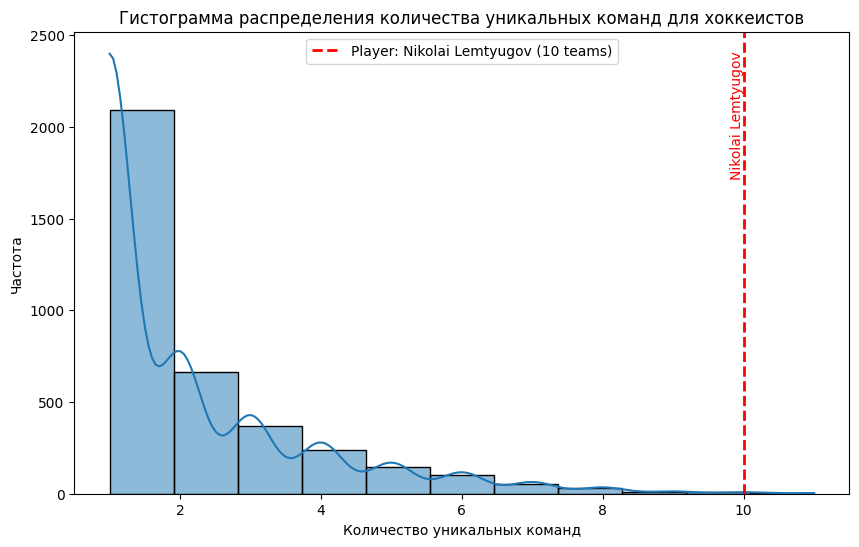

In [135]:
plt.figure(figsize=(10, 6))
sns.histplot(data=
             clubmates_teams, x='team',
             bins=11,
             kde=True)

# Отмечаем значение для игрока "Nikolai Lemtyugov"
player_id = '13705'
team_count = clubmates_teams.loc[clubmates_teams['player_id_player'] == player_id, 'team'].values[0]
plt.axvline(team_count, color='red', linestyle='dashed', linewidth=2, label=f'Player: Nikolai Lemtyugov ({team_count} teams)')

# Подпись игрока "Nikolai Lemtyugov" вертикально по красной оси
plt.text(team_count, plt.ylim()[1] * 0.96, 'Nikolai Lemtyugov', color='red', ha='right', va='top', fontsize=10, rotation='vertical')

plt.xlabel('Количество уникальных команд')
plt.ylabel('Частота')
plt.title('Гистограмма распределения количества уникальных команд для хоккеистов')
plt.legend()
plt.show()

Дальше работаем с датасетами clubmates_teams, lemtyugov_number.

In [136]:
# Объединение по общему столбцу 'player_id' и 'player_id_player'
merged_df = clubmates_teams.merge(lemtyugov_number,
                                  left_on='player_id_player',
                                  right_on='player_id')
merged_df.drop('player_id_player', axis=1, inplace=True)

merged_df = merged_df[['player_id', 'lemtyugov_number','team' ]]

In [137]:
merged_df

player_id  lemtyugov_number  team
0        22346                 2     1
1        22344                 2     1
2        22342                 2     1
3        22326                 2     1
4        22325                 2     1
...        ...               ...   ...
3715     13705                 0    10
3716       266                 2    10
3717       548                 2    11
3718     12990                 2    11
3719     14299                 2    11

[3720 rows x 3 columns]

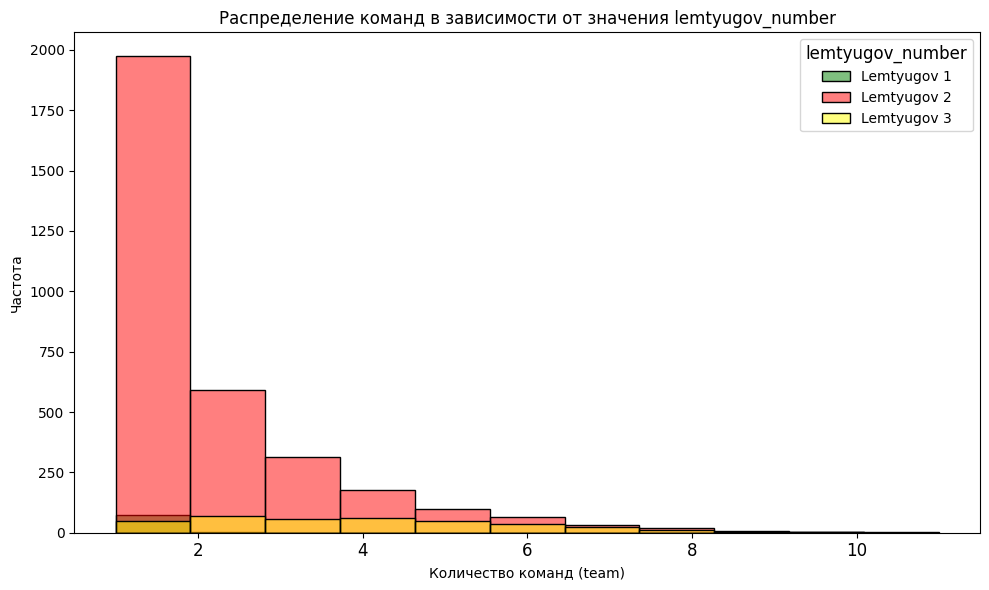

In [138]:
plt.figure(figsize=(10, 6))

custom_colors = ['blue', 'yellow', 'red', 'green']

sns.histplot(data=merged_df,
             x='team',
             hue='lemtyugov_number',
             kde=False,
             bins=11,
             palette=custom_colors)  # Использование новой палитры)

plt.xlabel('Количество команд (team)')
plt.ylabel('Частота')
plt.title('Распределение команд в зависимости от значения lemtyugov_number')

plt.legend(title='lemtyugov_number',
           title_fontsize='large',
           labels=['Lemtyugov 3', 'Lemtyugov 2', 'Lemtyugov 1'][::-1]
           )

plt.xticks(fontsize=12)
plt.tight_layout()

plt.show()

In [139]:
# Группировка по столбцу 'lemtyugov_number' и вычисление количества уникальных player_id и среднего значения по team
grouped_df = merged_df.groupby('lemtyugov_number').agg(
    player_id_count=('player_id', 'nunique'),  # Количество уникальных player_id
    average_team=('team', 'mean')  # Среднее значение по столбцу 'team'
).reset_index()

In [140]:
grouped_df

lemtyugov_number  player_id_count  average_team
0                 0                1         10.00
1                 1              357          3.82
2                 2             3287          1.89
3                 3               75          1.03

Видим, что чем ниже число Лемтюгова, тем больше количество команд, в которых играл хотккеист. Проверим это утверждение с помощью статистических методов.

In [141]:
correlation = merged_df['team'].corr(merged_df['lemtyugov_number'])
correlation

np.float64(-0.35352575378353124)

Коэффициент корреляции -0.3535 указывает на отрицательную слабую корреляцию между количеством команд ('team') и числом Лемтюгова ('lemtyugov_number'). Отрицательное значение коэффициента говорит о том, что при увеличении значения 'team', значение 'lemtyugov_number' склонно к уменьшению, и наоборот.

Такая корреляция не является сильной и не позволяет сделать однозначный вывод о прямой зависимости между этими двумя переменными. Однако она может указывать на то, что в целом у хоккеистов с более высоким значением количества команд (team), то есть игравших в большем количестве команд, есть склонность к меньшему числу Лемтюгова, то есть более сильной близости к легендарному хоккеисту.

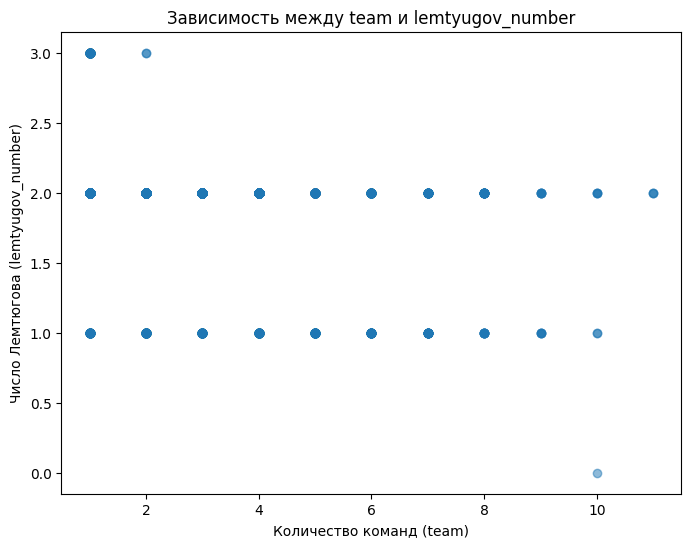

In [142]:
plt.figure(figsize=(8, 6))
plt.scatter(merged_df['team'], merged_df['lemtyugov_number'], alpha=0.5)
plt.xlabel('Количество команд (team)')
plt.ylabel('Число Лемтюгова (lemtyugov_number)')
plt.title('Зависимость между team и lemtyugov_number')
plt.show()

На графике рассеяния видно точки, представляющие каждую запись датафрейма. Точки расположены преимущественно вокруг линии или формируют какую-либо общую форму (прямую линию), это может указывать на наличие связи между количеством команд и числом Лемтюгова.

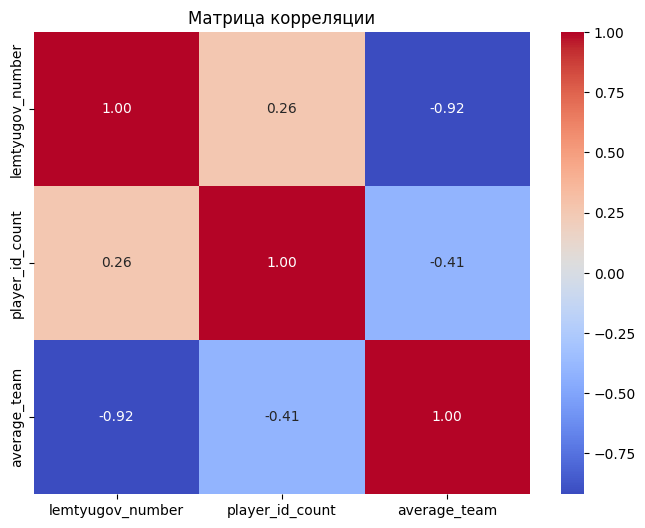

In [143]:
correlation_matrix = grouped_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляции')
plt.show()

Разделим данные на три выборки по значениям числа Лемтюгова 1, 2, 3. Число 0 - только у самого Лемтюгова (и в выборке будет только один человек, что недостаточно), поэтому число 0 не будем рассматривать.

In [144]:
sample_1 = merged_df[merged_df['lemtyugov_number'] == 1]['team']
sample_2 = merged_df[merged_df['lemtyugov_number'] == 2]['team']
sample_3 = merged_df[merged_df['lemtyugov_number'] == 3]['team']

Для работы с несколькими выборками будем использовать метод ANOVA.

In [145]:
# Проведение однофакторного дисперсионного анализа (ANOVA)
f_statistic, p_value = stats.f_oneway(sample_1, sample_2, sample_3)

print("F-статистика:", f_statistic)
print("p-значение:", p_value)

F-статистика: 273.11281629747526
p-значение: 2.1685096926300114e-111


Значение F-статистики равное 273.11 и крайне маленькое p-значение (2.17e-111) указывают на то, что существуют статистически значимые различия между средними значениями 'team' в трех выборках с числом Лемтюгова 1, 2 и 3.

Таким образом, гипотезу о равенстве средних можно считать отклоненной. Это говорит о том, что средние значения количества команд ('average_team') значимо различаются в зависимости от числа Лемтюгова.

Для более полного анализа, также важно проверить предположения, лежащие в основе ANOVA, включая нормальность распределения данных и равенство дисперсий. Также можно провести дополнительные пост-хок анализы, чтобы выявить, между какими именно группами наблюдаются статистически значимые различия.


In [146]:
# Проверка равенства дисперсий
statistic, p_value = stats.levene(sample_1, sample_2, sample_3)

print("Тест Левена:")
print("Статистика:", statistic)
print("p-значение:", p_value)

Тест Левена:
Статистика: 63.77807295446909
p-значение: 5.838751648517939e-28


Значение статистики теста Левена равное 63.78 и очень маленькое p-значение (5.84e-28) указывают на то, что дисперсии между выборками с числом Лемтюгова 1, 2 и 3 статистически значимо отличаются. Таким образом, гипотезу о равенстве дисперсий можно отклонить.

Учитывая результаты теста Левена, для проведения однофакторного дисперсионного анализа (ANOVA) можно использовать методы, учитывающие неоднородность дисперсий, например, Welch's ANOVA.

In [147]:
# Проведение Welch's ANOVA с использованием pingouin
anova_result = pg.welch_anova(data=merged_df, dv='team', between='lemtyugov_number')
anova_result

Source  ddof1    ddof2      F  p-unc  np2
0  lemtyugov_number      3 1,096.05 415.61   0.00 0.13

Предоставленные результаты Welch's ANOVA показывают следующие статистики:

* Source: Источник вариации (фактор), для которого была выполнена анализ.
* ddof1: Степени свободы числителя.
* ddof2: Степени свободы знаменателя.
* F: Значение статистики F (F-статистика).
* p-unc: Двустороннее p-значение для проверки нулевой гипотезы о равенстве средних.
* np2: Коэффициент детерминации (effect size) для данного фактора.

В данном случае, анализ выполнен для фактора 'lemtyugov_number' с тремя уровнями (1, 2 и 3), и результаты указывают на следующее:

Значение статистики F (F-статистика) равно 415.61.
Двустороннее p-значение (p-unc) очень маленькое (0.00), что указывает на статистически значимые различия в средних значениях 'team' для трех уровней числа Лемтюгова.
Коэффициент детерминации (np2) равен 0.13, что означает, что фактор 'lemtyugov_number' объясняет около 13% дисперсии в значениях 'team'.
Таким образом, результаты подтверждают статистически значимые различия в средних значениях 'team' между группами с разными значениями числа Лемтюгова (1, 2 и 3), и числовое значение коэффициента детерминации (effect size) показывает средний размер эффекта данного фактора.

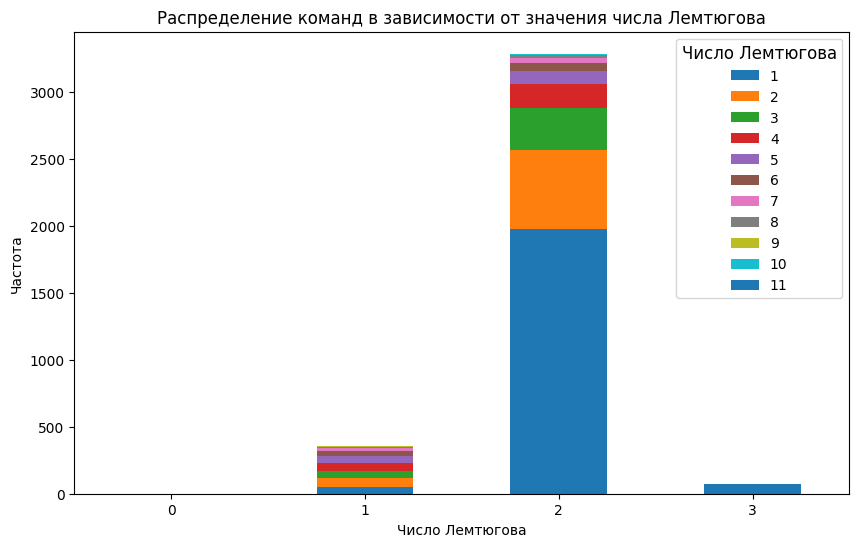

In [148]:
merged_df.groupby('lemtyugov_number')['team'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Число Лемтюгова')
plt.ylabel('Частота')
plt.title('Распределение команд в зависимости от значения числа Лемтюгова')
plt.legend(title='Число Лемтюгова', title_fontsize='large')
plt.xticks(rotation=360, fontsize=10)
#plt.tight_layout()
plt.show()

In [149]:
merged_df[merged_df['lemtyugov_number'] != 0]

player_id  lemtyugov_number  team
0        22346                 2     1
1        22344                 2     1
2        22342                 2     1
3        22326                 2     1
4        22325                 2     1
...        ...               ...   ...
3714     13253                 1    10
3716       266                 2    10
3717       548                 2    11
3718     12990                 2    11
3719     14299                 2    11

[3719 rows x 3 columns]

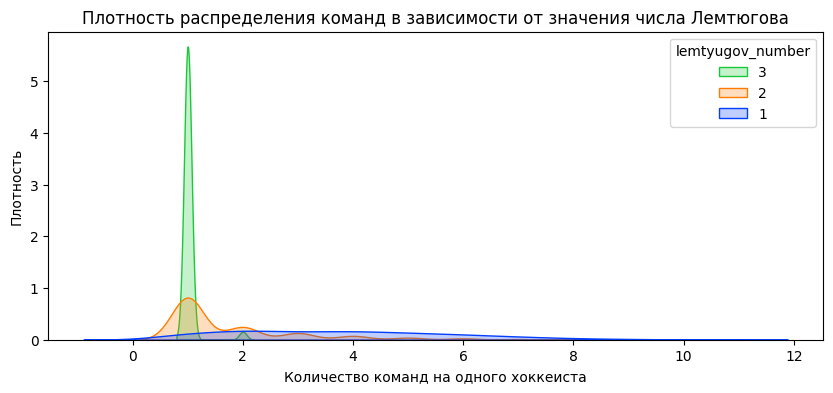

In [150]:
plt.figure(figsize=(10, 4))
sns.kdeplot(data=merged_df[merged_df['lemtyugov_number'] != 0],
            x='team',
            hue='lemtyugov_number',
            fill=True,
            common_norm=False,
            palette='bright'
            )
plt.xlabel('Количество команд на одного хоккеиста')
plt.ylabel('Плотность')
plt.title('Плотность распределения команд в зависимости от значения числа Лемтюгова')
plt.legend(title='lemtyugov_number', loc='upper right', labels=['3', '2', '1'])
plt.show()

Визуально график плотности распределения выглядит как гладкая кривая, которая описывает, какие значения вероятности более вероятны или менее вероятны в данном наборе данных.

## Медианное значение числа Лемтюгова. Изменение этого значения от сезона к сезону

### Медианное значение числа Лемтюгова

Рассчитаем медианное значение числа Лемтюгова.

In [158]:
lemtyugov_number['lemtyugov_number'].median()

2.0

In [159]:
merged_df['lemtyugov_number'].median()

2.0

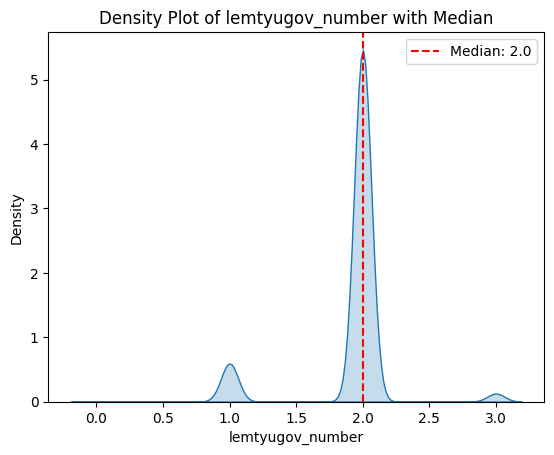

In [160]:
median_value = merged_df['lemtyugov_number'].median()
sns.kdeplot(data=merged_df['lemtyugov_number'], shade=True)
# добавим отметку медианы на графике
plt.axvline(x=median_value, color='red', linestyle='--', label=f'Median: {median_value}')
plt.xlabel('lemtyugov_number')
plt.ylabel('Density')
plt.title('Density Plot of lemtyugov_number with Median')
plt.legend()
plt.show()

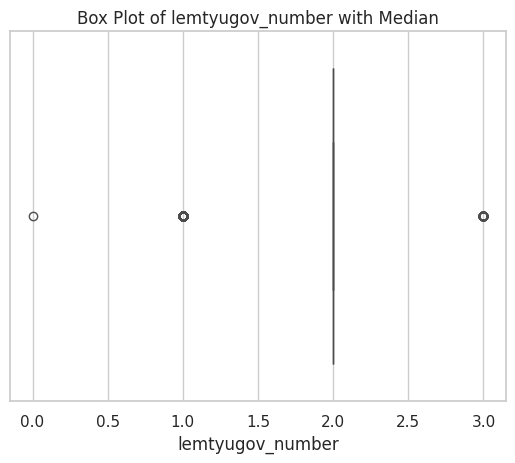

In [161]:
sns.set(style="whitegrid")
sns.boxplot(data=merged_df, x='lemtyugov_number')
plt.xlabel('lemtyugov_number')
plt.title('Box Plot of lemtyugov_number with Median')
plt.show()

Медианное значение - 2.

### Изменение этого значения от сезона к сезону

Далее рассмотрим изменение числа от сезона к сезону:

In [162]:
players.head()

player player_id          team start_date   end_date
0  Juhamatti Aaltonen     16785       Jokerit 2014-09-04 2016-03-02
1  Juhamatti Aaltonen     16785  Metallurg Mg 2010-09-09 2012-03-22
2       Miro Aaltonen     17585        Vityaz 2021-09-02 2022-01-11
3       Miro Aaltonen     17585           SKA 2019-12-17 2021-02-27
4       Miro Aaltonen     17585        Vityaz 2016-08-27 2019-12-09

In [163]:
players['start_year'] = players['start_date'].dt.year
players['end_year'] = players['end_date'].dt.year

In [164]:
#players.head()

In [165]:
season_start_date_mapping = {
    '2008': '02-09-08',
    '2009': '10-09-09',
    '2010': '09-09-10',
    '2011': '07-09-11',
    '2012': '04-09-12',
    '2013': '04-09-13',
    '2014': '03-09-14',
    '2015': '24-08-15',
    '2016': '22-08-16',
    '2017': '21-08-17',
    '2018': '01-09-18',
    '2019': '01-09-19',
    '2020': '02-09-20',
    '2021': '01-09-21',
    '2022': '01-09-22',
    '2023': '01-09-23'
}

In [166]:
season_end_date_mapping = {
    '2009': '12-04-09',
    '2010': '27-04-10',
    '2011': '16-04-11',
    '2012': '25-04-12',
    '2013': '17-04-13',
    '2014': '30-04-14',
    '2015': '19-04-15',
    '2016': '19-04-16',
    '2017': '16-04-17',
    '2018': '01-03-18',
    '2019': '22-02-19',
    '2020': '27-02-20',
    '2021': '28-04-21',
    '2022': '30-04-22',
    '2023': '29-04-23',
    '2023': '29-04-23'
}

In [167]:
# Создание функций для получения дат начала и конца сезона по году из словарей
def get_season_start(year):
    return pd.to_datetime(season_start_date_mapping[str(year)], format='%d-%m-%y')

def get_season_end(year):
    return pd.to_datetime(season_end_date_mapping[str(year)], format='%d-%m-%y')

In [168]:
players['season_start'] = players['start_year'].apply(get_season_start)

In [169]:
players_2014 = players[players['start_year']==2014]
players_2014

player player_id          team start_date   end_date  \
0      Juhamatti Aaltonen     16785       Jokerit 2014-09-04 2016-03-02   
18          Rodrigo Abols     20861      Dinamo R 2014-12-27 2015-02-24   
52             Ari Ahonen     18767       Admiral 2014-09-04 2014-09-27   
64        Rafael Akhmetov     14914          Amur 2014-12-24 2015-09-20   
65        Rafael Akhmetov     14914      HC Sochi 2014-09-08 2014-12-14   
...                   ...       ...           ...        ...        ...   
8106         Airat Ziazov     16217          Ugra 2014-11-06 2014-11-29   
8116  Stanislav Zinchenko     18981         Barys 2014-10-12 2014-10-27   
8136         Vitaly Zotov     15937  Metallurg Nk 2014-09-04 2014-12-10   
8154           Ilya Zubov      7211       Admiral 2014-01-13 2015-02-24   
8176      Maxim Zyuzyakin     15734          Lada 2014-09-08 2014-09-27   

      start_year  end_year season_start  
0           2014      2016   2014-09-03  
18          2014      2015   2014-09-03  
52          2014      2014   2014-09-03  
64          2014      2015   2014-09-03  
65          2014      2014   2014-09-03  
...          ...       ...          ...  
8106        2014      2014   2014-09-03  
8116        2014      2014   2014-09-03  
8136        2014      2014   2014-09-03  
8154        2014      2015   2014-09-03  
8176        2014      2014   2014-09-03  

[631 rows x 8 columns]

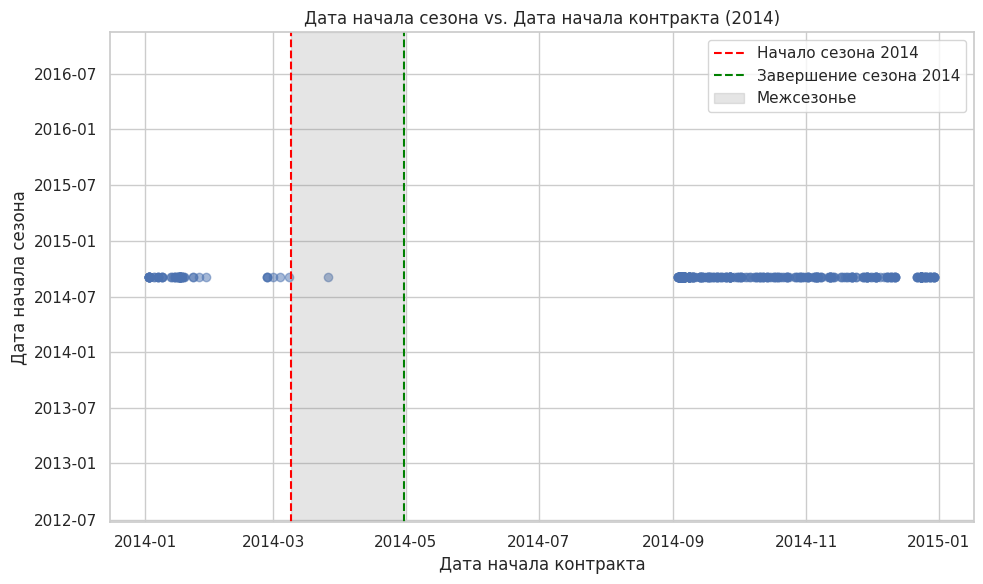

In [170]:
# Построение точечной диаграммы
plt.figure(figsize=(10, 6))

plt.scatter(players_2014['start_date'],  # здесь ось X
            players_2014['season_start'],  # здесь ось Y
            color='b',
            alpha=0.5)
plt.xlabel('Дата начала контракта')
plt.ylabel('Дата начала сезона')
plt.title('Дата начала сезона vs. Дата начала контракта (2014)')
plt.grid(True)

# Добавление красной и зеленой вертикальных линий для начала и завершения сезона 2014
plt.axvline(pd.to_datetime('03-09-14'), color='red', linestyle='--', label='Начало сезона 2014')
plt.axvline(pd.to_datetime('30-04-14'), color='green', linestyle='--', label='Завершение сезона 2014')

# Добавление заштрихованной области для межсезонья
plt.axvspan(pd.to_datetime('03-09-14'), pd.to_datetime('30-04-14'), alpha=0.2, color='gray', label='Межсезонье')

plt.legend()
plt.tight_layout()
plt.show()

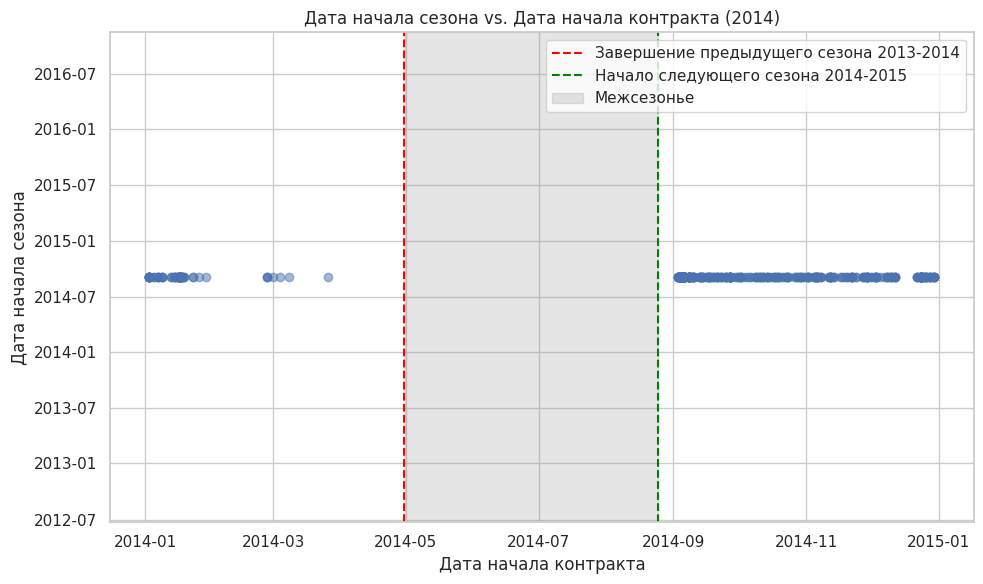

In [171]:
plt.figure(figsize=(10, 6))

plt.scatter(players_2014['start_date'],  # здесь ось X
            players_2014['season_start'],  # здесь ось Y
            color='b',
            alpha=0.5)
plt.xlabel('Дата начала контракта')
plt.ylabel('Дата начала сезона')
plt.title('Дата начала сезона vs. Дата начала контракта (2014)')
plt.grid(True)

# Добавление красной и зеленой вертикальных линий для начала и завершения сезонов
plt.axvline(pd.to_datetime('2014, 4, 30'), color='red', linestyle='--', label='Завершение предыдущего сезона 2013-2014')
plt.axvline(pd.to_datetime('2014, 8, 25'), color='green', linestyle='--', label='Начало следующего сезона 2014-2015')

# Добавление заштрихованной области для межсезонья
plt.axvspan(pd.to_datetime('2014, 4, 30'), pd.to_datetime('2014, 8, 25'), alpha=0.2, color='gray', label='Межсезонье')

plt.legend()
plt.tight_layout()
plt.show()

In [172]:
season_dates_khl = {
    '2008-2009': (datetime(2008, 9, 2), datetime(2009, 4, 12)),
    '2009-2010': (datetime(2009, 9, 10), datetime(2010, 4, 22)),
    '2010-2011': (datetime(2010, 9, 8), datetime(2011, 4, 20)),
    '2011-2012': (datetime(2011, 9, 7), datetime(2012, 4, 29)),
    '2012-2013': (datetime(2012, 9, 4), datetime(2013, 6, 24)),
    '2013-2014': (datetime(2013, 9, 4), datetime(2014, 4, 30)),
    '2014-2015': (datetime(2014, 8, 25), datetime(2015, 4, 30)),
    '2015-2016': (datetime(2015, 8, 24), datetime(2016, 4, 19)),
    '2016-2017': (datetime(2016, 8, 22), datetime(2017, 4, 16)),
    '2017-2018': (datetime(2017, 8, 21), datetime(2018, 4, 19)),
    '2018-2019': (datetime(2018, 9, 1), datetime(2019, 4, 19)),
    '2019-2020': (datetime(2019, 9, 1), datetime(2020, 3, 12)),
    '2020-2021': (datetime(2020, 9, 2), datetime(2021, 5, 7)),
    '2021-2022': (datetime(2021, 9, 1), datetime(2022, 4, 30)),
    '2022-2023': (datetime(2022, 9, 1), datetime(2023, 4, 29))
    }

In [173]:
players.head()

player player_id          team start_date   end_date  \
0  Juhamatti Aaltonen     16785       Jokerit 2014-09-04 2016-03-02   
1  Juhamatti Aaltonen     16785  Metallurg Mg 2010-09-09 2012-03-22   
2       Miro Aaltonen     17585        Vityaz 2021-09-02 2022-01-11   
3       Miro Aaltonen     17585           SKA 2019-12-17 2021-02-27   
4       Miro Aaltonen     17585        Vityaz 2016-08-27 2019-12-09   

   start_year  end_year season_start  
0        2014      2016   2014-09-03  
1        2010      2012   2010-09-09  
2        2021      2022   2021-09-01  
3        2019      2021   2019-09-01  
4        2016      2019   2016-08-22

In [174]:
# Функция для определения сезона на основе даты
def get_season(date):
    for season, (start_date, end_date) in season_dates_khl.items():
        if start_date <= date <= end_date:
            return season
    return None

In [175]:
# Применяем функцию к столбцу 'start_date' и создаем новый столбец 'season_on'
players['season_on'] = players['start_date'].apply(get_season)

In [176]:
# Применяем функцию к столбцу 'start_date' и создаем новый столбец 'season_on'
players['season_off'] = players['end_date'].apply(get_season)

In [177]:
players

player player_id            team start_date   end_date  \
0     Juhamatti Aaltonen     16785         Jokerit 2014-09-04 2016-03-02   
1     Juhamatti Aaltonen     16785    Metallurg Mg 2010-09-09 2012-03-22   
2          Miro Aaltonen     17585          Vityaz 2021-09-02 2022-01-11   
3          Miro Aaltonen     17585             SKA 2019-12-17 2021-02-27   
4          Miro Aaltonen     17585          Vityaz 2016-08-27 2019-12-09   
...                  ...       ...             ...        ...        ...   
8174       Dmitry Zyuzin     13961    Metallurg Nk 2010-10-14 2011-02-16   
8175       Dmitry Zyuzin     13961  Salavat Yulaev 2008-10-27 2008-10-27   
8176     Maxim Zyuzyakin     15734            Lada 2014-09-08 2014-09-27   
8177     Maxim Zyuzyakin     15734    Metallurg Nk 2013-09-05 2013-10-03   
8178     Maxim Zyuzyakin     15734       Lokomotiv 2010-03-05 2011-01-04   

      start_year  end_year season_start  season_on season_off  
0           2014      2016   2014-09-03  2014-2015  2015-2016  
1           2010      2012   2010-09-09  2010-2011  2011-2012  
2           2021      2022   2021-09-01  2021-2022  2021-2022  
3           2019      2021   2019-09-01  2019-2020  2020-2021  
4           2016      2019   2016-08-22  2016-2017  2019-2020  
...          ...       ...          ...        ...        ...  
8174        2010      2011   2010-09-09  2010-2011  2010-2011  
8175        2008      2008   2008-09-02  2008-2009  2008-2009  
8176        2014      2014   2014-09-03  2014-2015  2014-2015  
8177        2013      2013   2013-09-04  2013-2014  2013-2014  
8178        2010      2011   2010-09-09  2009-2010  2010-2011  

[8179 rows x 10 columns]

In [178]:
players.isnull().sum()

player           0
player_id        0
team             0
start_date       0
end_date         0
start_year       0
end_year         0
season_start     0
season_on        0
season_off      36
dtype: int64

In [179]:
players[players['season_off'].isnull()]

player player_id     team start_date   end_date  \
357        Yury I. Babenko     10892   HC MVD 2009-09-12 2010-04-27   
374        Alexei Badyukov      4087  Ak Bars 2008-12-23 2010-04-27   
758       Alexander Boikov     10855   HC MVD 2009-09-18 2010-04-27   
1300         Roman Derlyuk     13786   HC MVD 2008-09-02 2010-04-27   
1320       Yury Dobryshkin      4699   HC MVD 2009-10-05 2010-04-27   
1448          Matt Ellison     15217   HC MVD 2009-09-12 2010-04-27   
1639       Evgeny Fyodorov      4014   HC MVD 2009-09-12 2010-04-27   
1735       Michael Garnett     14900   HC MVD 2008-09-02 2010-04-27   
1915     Vladimir Gorbunov      3538   HC MVD 2008-09-02 2010-04-27   
2267        Hannes Hyvonen     15545  Ak Bars 2010-01-18 2010-04-27   
2947         Denis Kokarev      3507   HC MVD 2008-09-02 2010-04-27   
3457       Roman Kukumberg     13683  Ak Bars 2010-02-01 2010-04-23   
3552       Andrei Kuzmenko     19215     CSKA 2014-09-14 2018-04-22   
4560        Denis Mosalyov     14444   HC MVD 2008-09-05 2010-04-27   
4585     Andrei Mukhachyov      3552  Ak Bars 2009-01-08 2010-04-27   
4845           Filip Novak     15248   HC MVD 2009-09-12 2010-04-27   
4925          Atte Ohtamaa     21802  Ak Bars 2016-08-23 2018-04-22   
5215      Andrei Pervyshin       279  Ak Bars 2008-09-03 2010-04-27   
5262         Kirill Petrov     14622     CSKA 2016-01-04 2018-04-22   
5363           Geoff Platt     15373     CSKA 2015-08-24 2018-04-20   
5499   Nikita A. Popugayev     22684     CSKA 2017-11-22 2018-04-22   
6134    Artyom M. Sergeyev     16675     CSKA 2015-11-10 2018-04-22   
6309    Alexander Shibayev     14321   HC MVD 2008-09-13 2010-04-27   
6436       Mikhail Sidorov     21011  Ak Bars 2015-12-23 2018-04-22   
6785     Gennady Stolyarov       548   HC MVD 2010-03-07 2010-04-27   
6797         Martin Strbak      5454   HC MVD 2009-09-12 2010-04-27   
7091       Vasily Tokranov     14732  Ak Bars 2009-03-27 2018-04-22   
7125       Pavel Trakhanov      4367   HC MVD 2008-09-02 2010-04-27   
7187       Alexei Tsvetkov      6336   HC MVD 2008-09-02 2010-04-27   
7240         Alexei Ugarov     14285   HC MVD 2008-09-02 2010-04-27   
7392         Maxim Velikov      4336   HC MVD 2008-09-02 2010-04-27   
7502     Alexei Vl. Volkov      6488   HC MVD 2009-09-12 2010-04-27   
7522  Konstantin N. Volkov      3404   HC MVD 2009-09-12 2010-04-27   
7905        Mikhail Yunkov       595  Ak Bars 2009-09-12 2010-04-27   
7942      Ruslan Zainullin      4703   HC MVD 2008-09-07 2010-04-23   
8038      Vladimir Zharkov     14527     CSKA 2012-09-05 2018-04-22   

      start_year  end_year season_start  season_on season_off  
357         2009      2010   2009-09-10  2009-2010       None  
374         2008      2010   2008-09-02  2008-2009       None  
758         2009      2010   2009-09-10  2009-2010       None  
1300        2008      2010   2008-09-02  2008-2009       None  
1320        2009      2010   2009-09-10  2009-2010       None  
1448        2009      2010   2009-09-10  2009-2010       None  
1639        2009      2010   2009-09-10  2009-2010       None  
1735        2008      2010   2008-09-02  2008-2009       None  
1915        2008      2010   2008-09-02  2008-2009       None  
2267        2010      2010   2010-09-09  2009-2010       None  
2947        2008      2010   2008-09-02  2008-2009       None  
3457        2010      2010   2010-09-09  2009-2010       None  
3552        2014      2018   2014-09-03  2014-2015       None  
4560        2008      2010   2008-09-02  2008-2009       None  
4585        2009      2010   2009-09-10  2008-2009       None  
4845        2009      2010   2009-09-10  2009-2010       None  
4925        2016      2018   2016-08-22  2016-2017       None  
5215        2008      2010   2008-09-02  2008-2009       None  
5262        2016      2018   2016-08-22  2015-2016       None  
5363        2015      2018   2015-08-24  2015-2016       None  
5499        2017      2018   2017-08-21  2017-20

In [180]:
season_dataframe = pd.DataFrame.from_dict(season_dates_khl, orient='index', columns=['Start_Date', 'End_Date'])
season_dataframe.index.name = 'Season'

In [181]:
season_dataframe

Start_Date   End_Date
Season                         
2008-2009 2008-09-02 2009-04-12
2009-2010 2009-09-10 2010-04-22
2010-2011 2010-09-08 2011-04-20
2011-2012 2011-09-07 2012-04-29
2012-2013 2012-09-04 2013-06-24
2013-2014 2013-09-04 2014-04-30
2014-2015 2014-08-25 2015-04-30
2015-2016 2015-08-24 2016-04-19
2016-2017 2016-08-22 2017-04-16
2017-2018 2017-08-21 2018-04-19
2018-2019 2018-09-01 2019-04-19
2019-2020 2019-09-01 2020-03-12
2020-2021 2020-09-02 2021-05-07
2021-2022 2021-09-01 2022-04-30
2022-2023 2022-09-01 2023-04-29

In [182]:
fig = px.timeline(season_dataframe,
                  x_start="Start_Date",
                  x_end="End_Date",
                  y=season_dataframe.index,
                  color=season_dataframe.index,
                 title = 'Сезоны КХЛ')
#fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
fig.show()

In [183]:
season_dataframe

Start_Date   End_Date
Season                         
2008-2009 2008-09-02 2009-04-12
2009-2010 2009-09-10 2010-04-22
2010-2011 2010-09-08 2011-04-20
2011-2012 2011-09-07 2012-04-29
2012-2013 2012-09-04 2013-06-24
2013-2014 2013-09-04 2014-04-30
2014-2015 2014-08-25 2015-04-30
2015-2016 2015-08-24 2016-04-19
2016-2017 2016-08-22 2017-04-16
2017-2018 2017-08-21 2018-04-19
2018-2019 2018-09-01 2019-04-19
2019-2020 2019-09-01 2020-03-12
2020-2021 2020-09-02 2021-05-07
2021-2022 2021-09-01 2022-04-30
2022-2023 2022-09-01 2023-04-29

In [184]:
players.head()

player player_id          team start_date   end_date  \
0  Juhamatti Aaltonen     16785       Jokerit 2014-09-04 2016-03-02   
1  Juhamatti Aaltonen     16785  Metallurg Mg 2010-09-09 2012-03-22   
2       Miro Aaltonen     17585        Vityaz 2021-09-02 2022-01-11   
3       Miro Aaltonen     17585           SKA 2019-12-17 2021-02-27   
4       Miro Aaltonen     17585        Vityaz 2016-08-27 2019-12-09   

   start_year  end_year season_start  season_on season_off  
0        2014      2016   2014-09-03  2014-2015  2015-2016  
1        2010      2012   2010-09-09  2010-2011  2011-2012  
2        2021      2022   2021-09-01  2021-2022  2021-2022  
3        2019      2021   2019-09-01  2019-2020  2020-2021  
4        2016      2019   2016-08-22  2016-2017  2019-2020

In [185]:
players_2008 = players[
    players['start_date']  # дата прихода игрока в команду
        < datetime(2009, 4, 12) # дата завершения сезона
        ]
players_2008

player player_id            team start_date   end_date  \
5     Ruslan Abdrakhmanov     13041            Amur 2008-09-02 2009-02-14   
14         Denis Abdullin     13873          HC MVD 2008-09-02 2009-11-23   
37     Dmitry Afanasenkov     13490        Dynamo M 2008-09-03 2009-09-24   
49            Ivan Ageyev     15376            CSKA 2008-09-22 2008-09-22   
56          Johan Akerman     15218       Lokomotiv 2008-09-02 2009-04-12   
...                   ...       ...             ...        ...        ...   
8146       Sergei Zuborev      5336          Vityaz 2008-09-02 2010-10-29   
8161         Andrei Zuyev      6335         Traktor 2008-12-26 2008-12-26   
8163       Sergei Zvyagin      2820       Lokomotiv 2008-09-02 2009-04-12   
8173        Andrei Zyuzin     13702             SKA 2008-09-03 2010-10-18   
8175        Dmitry Zyuzin     13961  Salavat Yulaev 2008-10-27 2008-10-27   

      start_year  end_year season_start  season_on season_off  
5           2008      2009   2008-09-02  2008-2009  2008-2009  
14          2008      2009   2008-09-02  2008-2009  2009-2010  
37          2008      2009   2008-09-02  2008-2009  2009-2010  
49          2008      2008   2008-09-02  2008-2009  2008-2009  
56          2008      2009   2008-09-02  2008-2009  2008-2009  
...          ...       ...          ...        ...        ...  
8146        2008      2010   2008-09-02  2008-2009  2010-2011  
8161        2008      2008   2008-09-02  2008-2009  2008-2009  
8163        2008      2009   2008-09-02  2008-2009  2008-2009  
8173        2008      2010   2008-09-02  2008-2009  2010-2011  
8175        2008      2008   2008-09-02  2008-2009  2008-2009  

[872 rows x 10 columns]

In [186]:
season_dates_khl

{'2008-2009': (datetime.datetime(2008, 9, 2, 0, 0),
  datetime.datetime(2009, 4, 12, 0, 0)),
 '2009-2010': (datetime.datetime(2009, 9, 10, 0, 0),
  datetime.datetime(2010, 4, 22, 0, 0)),
 '2010-2011': (datetime.datetime(2010, 9, 8, 0, 0),
  datetime.datetime(2011, 4, 20, 0, 0)),
 '2011-2012': (datetime.datetime(2011, 9, 7, 0, 0),
  datetime.datetime(2012, 4, 29, 0, 0)),
 '2012-2013': (datetime.datetime(2012, 9, 4, 0, 0),
  datetime.datetime(2013, 6, 24, 0, 0)),
 '2013-2014': (datetime.datetime(2013, 9, 4, 0, 0),
  datetime.datetime(2014, 4, 30, 0, 0)),
 '2014-2015': (datetime.datetime(2014, 8, 25, 0, 0),
  datetime.datetime(2015, 4, 30, 0, 0)),
 '2015-2016': (datetime.datetime(2015, 8, 24, 0, 0),
  datetime.datetime(2016, 4, 19, 0, 0)),
 '2016-2017': (datetime.datetime(2016, 8, 22, 0, 0),
  datetime.datetime(2017, 4, 16, 0, 0)),
 '2017-2018': (datetime.datetime(2017, 8, 21, 0, 0),
  datetime.datetime(2018, 4, 19, 0, 0)),
 '2018-2019': (datetime.datetime(2018, 9, 1, 0, 0),
  datetime.da

In [187]:
season_dates_khl['2008-2009']

(datetime.datetime(2008, 9, 2, 0, 0), datetime.datetime(2009, 4, 12, 0, 0))

In [188]:
season_dates_khl['2008-2009'][-1]

datetime.datetime(2009, 4, 12, 0, 0)

In [189]:
for key, date_list in season_dates_khl.items():
    last_date = date_list[-1]  # Получаем последнюю дату в списке

    print(f"Key: {key}, Last Date: {last_date}")

Key: 2008-2009, Last Date: 2009-04-12 00:00:00
Key: 2009-2010, Last Date: 2010-04-22 00:00:00
Key: 2010-2011, Last Date: 2011-04-20 00:00:00
Key: 2011-2012, Last Date: 2012-04-29 00:00:00
Key: 2012-2013, Last Date: 2013-06-24 00:00:00
Key: 2013-2014, Last Date: 2014-04-30 00:00:00
Key: 2014-2015, Last Date: 2015-04-30 00:00:00
Key: 2015-2016, Last Date: 2016-04-19 00:00:00
Key: 2016-2017, Last Date: 2017-04-16 00:00:00
Key: 2017-2018, Last Date: 2018-04-19 00:00:00
Key: 2018-2019, Last Date: 2019-04-19 00:00:00
Key: 2019-2020, Last Date: 2020-03-12 00:00:00
Key: 2020-2021, Last Date: 2021-05-07 00:00:00
Key: 2021-2022, Last Date: 2022-04-30 00:00:00
Key: 2022-2023, Last Date: 2023-04-29 00:00:00


In [190]:
players.head()

player player_id          team start_date   end_date  \
0  Juhamatti Aaltonen     16785       Jokerit 2014-09-04 2016-03-02   
1  Juhamatti Aaltonen     16785  Metallurg Mg 2010-09-09 2012-03-22   
2       Miro Aaltonen     17585        Vityaz 2021-09-02 2022-01-11   
3       Miro Aaltonen     17585           SKA 2019-12-17 2021-02-27   
4       Miro Aaltonen     17585        Vityaz 2016-08-27 2019-12-09   

   start_year  end_year season_start  season_on season_off  
0        2014      2016   2014-09-03  2014-2015  2015-2016  
1        2010      2012   2010-09-09  2010-2011  2011-2012  
2        2021      2022   2021-09-01  2021-2022  2021-2022  
3        2019      2021   2019-09-01  2019-2020  2020-2021  
4        2016      2019   2016-08-22  2016-2017  2019-2020

In [191]:
players_short = players[['player_id', 'team', 'start_date', 'end_date']]
players_short.head()

player_id          team start_date   end_date
0     16785       Jokerit 2014-09-04 2016-03-02
1     16785  Metallurg Mg 2010-09-09 2012-03-22
2     17585        Vityaz 2021-09-02 2022-01-11
3     17585           SKA 2019-12-17 2021-02-27
4     17585        Vityaz 2016-08-27 2019-12-09

#### Число Лемтюгова по сезонам

In [192]:
# Создаем пустой словарь для хранения датафреймов с игроками по сезонам
season_dataframes = {}

# Итерируемся по ключам (названиям сезонов) в словаре сезонов
for season, (start_date, end_date) in season_dates_khl.items():

    # Обрезаем полный датафрейм с игроками, чтобы данные были только за нужный период времени (сезон)

    season_df = players_short[players['start_date'] < end_date] # игрок пришел раньше, чем заончился сезон

    # Сохраняем обрезанный DataFrame в словаре под ключом сезона
    season_dataframes[season] = season_df

In [193]:
season_dataframes['2014-2015']

player_id            team start_date   end_date
0        16785         Jokerit 2014-09-04 2016-03-02
1        16785    Metallurg Mg 2010-09-09 2012-03-22
5        13041            Amur 2008-09-02 2009-02-14
9        13873         Traktor 2013-10-16 2014-09-23
10       13873         Ak Bars 2012-09-10 2013-09-19
...        ...             ...        ...        ...
8174     13961    Metallurg Nk 2010-10-14 2011-02-16
8175     13961  Salavat Yulaev 2008-10-27 2008-10-27
8176     15734            Lada 2014-09-08 2014-09-27
8177     15734    Metallurg Nk 2013-09-05 2013-10-03
8178     15734       Lokomotiv 2010-03-05 2011-01-04

[4015 rows x 4 columns]

In [194]:
# Выводим количество строк в обрезанных датафреймах для каждого сезона
for season, season_df in season_dataframes.items():
    num_rows = len(season_df)
    print(f"Season: {season}, Number of Rows: {num_rows}")

Season: 2008-2009, Number of Rows: 872
Season: 2009-2010, Number of Rows: 1302
Season: 2010-2011, Number of Rows: 1771
Season: 2011-2012, Number of Rows: 2216
Season: 2012-2013, Number of Rows: 2798
Season: 2013-2014, Number of Rows: 3414
Season: 2014-2015, Number of Rows: 4015
Season: 2015-2016, Number of Rows: 4603
Season: 2016-2017, Number of Rows: 5176
Season: 2017-2018, Number of Rows: 5754
Season: 2018-2019, Number of Rows: 6246
Season: 2019-2020, Number of Rows: 6736
Season: 2020-2021, Number of Rows: 7256
Season: 2021-2022, Number of Rows: 7753
Season: 2022-2023, Number of Rows: 8179


Теперь нужно посчитать число Лемтюгова также как и раньше, но по датафрейму, который соотвествует сезону:

*   получаем список одноклубников, объединяя датафрейм сам с собой по команде с учетом дубликатов и временных интервалов;
*   создаем граф и находим число Лемтюгова.

In [195]:
# Создаем пустой словарь для хранения объединенных датафреймов по командам
clubmates_dataframes = {}

# Итерируемся по ключам (названиям сезонов) и датафреймам в словаре season_dataframes
for season, season_df in season_dataframes.items():

    # Объединяем датафрейм сам с собой по столбцу 'team' и обрезаем по условиям
    clubmates = season_df.merge(season_df, on='team', suffixes=('_player', '_clubmate'))
    clubmates = clubmates[
                (clubmates['player_id_player'] != clubmates['player_id_clubmate']) &
                (clubmates['start_date_player'] <= clubmates['end_date_clubmate']) &
                (clubmates['start_date_clubmate'] <= clubmates['end_date_player'])
            ]

   # тут группируем по айди игрока и создаем список одноклубников
    clubmates = clubmates.groupby('player_id_player')['player_id_clubmate'].apply(list).reset_index()
    clubmates.rename(columns={'player_id_player': 'player_id', 'player_id_clubmate': 'clubmates_id'}, inplace=True)

    clubmates_dataframes[season] = clubmates

In [196]:
clubmates_dataframes['2014-2015']

player_id  \
0            1   
1        10162   
2        10176   
3        10427   
4        10541   
...        ...   
2073      9859   
2074      9860   
2075      9862   
2076      9863   
2077        99   

                                                                                                                                                                                                 clubmates_id  
0     [13873, 13490, 9435, 13923, 15889, 16119, 19294, 17292, 3607, 16118, 22027, 3920, 13916, 13805, 3945, 14982, 14887, 15732, 15482, 21983, 3614, 17754, 21111, 4014, 15977, 17632, 6440, 19058, 3538, ...  
1     [13162, 15958, 15681, 4544, 16643, 17650, 15317, 17649, 5261, 17130, 18983, 15122, 17560, 14392, 13707, 17680, 14410, 18810, 3511, 20939, 15451, 19045, 3634, 4531, 15519, 17844, 5416, 17845, 13724...  
2     [14267, 17210, 14364, 14498, 15308, 16827, 14856, 14590, 22266, 15301, 15301, 17829, 14769, 15201, 14613, 16696, 13446, 9467, 14864, 15413, 19452, 20197, 3582, 13964, 18, 13946, 15219, 15486, 1281...  
3             [14763, 14876, 4512, 13806, 14478, 6303, 13226, 13803, 15514, 6308, 14454, 9467, 5516, 4000, 13877, 4033, 14476, 11903, 15232, 13031, 5526, 4817, 14616, 4499, 14448, 15476, 15105, 392, 13928]  
4     [13873, 16221, 13490, 4508, 14909, 4799, 14647, 3989, 41, 6432, 5701, 6428, 15979, 15165, 13332, 14918, 15308, 6303, 17168, 16514, 4111, 14590, 15238, 15192, 15251, 15732, 16184, 15307, 11972, 148...  
...                                                                                                                                                                                                       ...  
2073  [3989, 15979, 14918, 4111, 15192, 15732, 16184, 14825, 10541, 14900, 14738, 15990, 14300, 17881, 14652, 13859, 4486, 16355, 15564, 16234, 17551, 13031, 22042, 19031, 5636, 372, 14430, 16178, 17862...  
2074  [13873, 13490, 9435, 3739, 16119, 13061, 3607, 16123, 16118, 3920, 13805, 13805, 14982, 4080, 14887, 15732, 725, 3614, 13863, 4537, 5694, 17632, 6440, 5307, 3995, 6485, 16810, 7016, 15127, 14299, ...  
2075  [18767, 15903, 16672, 18787, 17664, 15732, 16015, 13784, 16502, 18947, 20944, 18779, 19627, 19248, 15787, 16008, 16069, 587, 17625, 16456, 17553, 16400, 304, 13809, 14766, 13871, 20894, 19736, 163...  
2076  [18961, 3737, 3737, 16165, 14551, 5211, 4512, 4512, 14365, 14365, 4544, 15323, 15129, 21417, 3920, 16777, 4802, 4019, 21251, 17621, 15482, 17182, 16787, 16441, 15050, 4014, 17370, 15278, 3703, 178...  
2077  [15948, 13806, 15354, 171, 10942, 20937, 16646, 22258, 6357, 4241, 6347, 3997, 19403, 5851, 12800, 10900, 14671, 18342, 15953, 18764, 19711, 3593, 18485, 497, 17504, 15802, 3521, 449, 16423, 14691...  

[2078 rows x 2 columns]

In [197]:
# Выводим количество строк в датафреймах с одноклубниками для каждого сезона
for season, season_df in clubmates_dataframes.items():
    num_rows = len(season_df)
    print(f"Season: {season}, Number of Rows: {num_rows}")

Season: 2008-2009, Number of Rows: 802
Season: 2009-2010, Number of Rows: 1029
Season: 2010-2011, Number of Rows: 1202
Season: 2011-2012, Number of Rows: 1358
Season: 2012-2013, Number of Rows: 1614
Season: 2013-2014, Number of Rows: 1870
Season: 2014-2015, Number of Rows: 2078
Season: 2015-2016, Number of Rows: 2303
Season: 2016-2017, Number of Rows: 2513
Season: 2017-2018, Number of Rows: 2717
Season: 2018-2019, Number of Rows: 2902
Season: 2019-2020, Number of Rows: 3104
Season: 2020-2021, Number of Rows: 3352
Season: 2021-2022, Number of Rows: 3552
Season: 2022-2023, Number of Rows: 3720


Дальше нам нужно создать из полученных данных (отдельные датафреймы одноклубников по каждому сезону) графы по сезонам и посчитать число Лемтюгова.

In [198]:
# Создаем словарь словарей
clubmates_dataframes_dict = {}

# Итерируемся по ключам (названиям сезонов) и датафреймам
for season, clubmates in clubmates_dataframes.items():

    clubmates_dict = dict(zip(clubmates['player_id'], clubmates['clubmates_id']))

    clubmates_dataframes_dict[season] = clubmates_dict

In [199]:
#clubmates_dataframes_dict['2014-2015']['16673']

In [200]:
lemtyugov_number_dataframe = {}

for season, clubmates_dict in clubmates_dataframes_dict.items():

    # Создаем пустой граф
    G = nx.Graph()

    # Добавляем узлы (игроки) в граф
    for player, clubmates in clubmates_dict.items():
        G.add_node(player)

    # Добавляем ребра (связи между игроками)
    for player, clubmates in clubmates_dict.items():
        for clubmate in clubmates:
            G.add_edge(player, clubmate)

    # пользуемся графовым алгоритмом и высчитываем число Лемтюгова:
    shortest_paths = nx.single_source_shortest_path_length(G, source='13705')

    # создаем датафрейм, где у кажого айди игрока будет число Лемтюгова
    lemtyugov_number = pd.DataFrame(list(shortest_paths.items()), columns=['player_id', 'lemtyugov_number'])

    # итоговый датафрейм запишем под именем сезона в словарь датафреймов
    lemtyugov_number_dataframe[season] = lemtyugov_number

In [201]:
lemtyugov_number_dataframe['2014-2015']

player_id  lemtyugov_number
0        13705                 0
1        10541                 1
2        10769                 1
3        10992                 1
4        11014                 1
...        ...               ...
2073     21606                 3
2074     22020                 3
2075      4811                 3
2076     15275                 3
2077     15314                 3

[2078 rows x 2 columns]

Теперь для каждого датафрейма, соотвествующего сезону, надо посчитать медиану по столбцу lemtyugov_number.

In [202]:
# Создаем пустой список, в который будем добавлять результаты вычислений
results = []

# Задаем список значений, для которых будем подсчитывать количество записей
values_to_count = [0, 1, 2, 3, 4, 5, 6]

# Итерируемся по ключам словаря и вычисляем медиану для каждого датафрейма
for key, df in lemtyugov_number_dataframe.items():

    # посчитаем медиану:
    median = df['lemtyugov_number'].median()

    # посмотрим также другие статистические показатели:
    mean = df['lemtyugov_number'].mean()
    std_dev = df['lemtyugov_number'].std()
    min_val = df['lemtyugov_number'].min()
    max_val = df['lemtyugov_number'].max()

    player_id_nunique = df['player_id'].nunique()

    count = df['lemtyugov_number'].count()
    q1 = df['lemtyugov_number'].quantile(0.25)
    q3 = df['lemtyugov_number'].quantile(0.75)
    sum_val = df['lemtyugov_number'].sum()
    variance = df['lemtyugov_number'].var()
    coeff_var = std_dev / mean
    skewness = df['lemtyugov_number'].skew()
    kurtosis = df['lemtyugov_number'].kurtosis()

    # Подсчет количества записей для каждого значения из values_to_count
    count_per_value = {value: df['lemtyugov_number'][df['lemtyugov_number'] == value].count() for value in values_to_count}


    results.append({'key': key,
                    'median': median,
                    'mean': mean,
                    'std_dev': std_dev,
                    'min': min_val,
                    'max': max_val,
                    'player_id_nunique': player_id_nunique,
                    'count': count,
                    'q1': q1,
                    'q3': q3,
                    'sum': sum_val,
                    'variance': variance,
                    'coeff_var': coeff_var,
                    'skewness': skewness,
                    'kurtosis': kurtosis,
                    **count_per_value
                    })

# Создаем новый датафрейм из списка результатов
result_df = pd.DataFrame(results)

In [203]:
result_df

key  median  mean  std_dev  min  max  player_id_nunique  count   q1  \
0   2008-2009    4.00  4.15     1.00    0    6                774    774 4.00   
1   2009-2010    2.00  2.38     0.62    0    4               1029   1029 2.00   
2   2010-2011    2.00  2.23     0.56    0    3               1202   1202 2.00   
3   2011-2012    2.00  1.97     0.43    0    3               1358   1358 2.00   
4   2012-2013    2.00  1.91     0.39    0    3               1614   1614 2.00   
5   2013-2014    2.00  1.90     0.40    0    3               1870   1870 2.00   
6   2014-2015    2.00  1.87     0.39    0    3               2078   2078 2.00   
7   2015-2016    2.00  1.87     0.38    0    3               2303   2303 2.00   
8   2016-2017    2.00  1.87     0.36    0    3               2513   2513 2.00   
9   2017-2018    2.00  1.88     0.35    0    3               2717   2717 2.00   
10  2018-2019    2.00  1.89     0.35    0    3               2902   2902 2.00   
11  2019-2020    2.00  1.90     0.35    0    3               3104   3104 2.00   
12  2020-2021    2.00  1.91     0.34    0    3               3352   3352 2.00   
13  2021-2022    2.00  1.92     0.34    0    3               3552   3552 2.00   
14  2022-2023    2.00  1.92     0.33    0    3               3720   3720 2.00   

     q3  ...  coeff_var  skewness  kurtosis  0    1     2    3    4    5   6  
0  5.00  ...       0.24     -0.89      1.92  1   27     3  116  348  235  44  
1  3.00  ...       0.26     -0.49     -0.49  1   73   486  468    1    0   0  
2  3.00  ...       0.25     -0.02     -0.17  1   79   765  357    0    0   0  
3  2.00  ...       0.22     -0.24      2.66  1  144  1111  102    0    0   0  
4  2.00  ...       0.20     -0.91      3.08  1  202  1358   53    0    0   0  
5  2.00  ...       0.21     -0.87      2.56  1  256  1551   62    0    0   0  
6  2.00  ...       0.21     -1.28      2.23  1  311  1732   34    0    0   0  
7  2.00  ...       0.20     -1.40      2.53  1  327  1942   33    0    0   0  
8  2.00  ...       0.19     -1.58      2.78  1  343  2142   27    0    0   0  
9  2.00  ...       0.19     -1.78      3.03  1  357  2339   20    0    0   0  
10 2.00  ...       0.18     -1.76      3.51  1  357  2517   27    0    0   0  
11 2.00  ...       0.18     -1.53      3.92  1  357  2699   47    0    0   0  
12 2.00  ...       0.18     -1.60      4.50  1  357  2944   50    0    0   0  
13 2.00  ...       0.18     -1.44      4.82  1  357  3127   67    0    0   0  
14 2.00  ...       0.17     -1.40      5.12  1  357  3287   75    0    0   0  

[15 rows x 22 columns]

In [204]:
lemtyugov_by_season = result_df[['key', 'median', 'mean', 'max']]
lemtyugov_by_season

key  median  mean  max
0   2008-2009    4.00  4.15    6
1   2009-2010    2.00  2.38    4
2   2010-2011    2.00  2.23    3
3   2011-2012    2.00  1.97    3
4   2012-2013    2.00  1.91    3
5   2013-2014    2.00  1.90    3
6   2014-2015    2.00  1.87    3
7   2015-2016    2.00  1.87    3
8   2016-2017    2.00  1.87    3
9   2017-2018    2.00  1.88    3
10  2018-2019    2.00  1.89    3
11  2019-2020    2.00  1.90    3
12  2020-2021    2.00  1.91    3
13  2021-2022    2.00  1.92    3
14  2022-2023    2.00  1.92    3

In [205]:
# Путь к файлу на Google Drive
#file_path = '/content/drive/MyDrive/lemtyugov_by_season.csv'

# Сохранение датафрейма в CSV-файле
#lemtyugov_by_season.to_csv(file_path, index=False)

# Скачивание файла на локальный компьютер
#files.download(file_path)

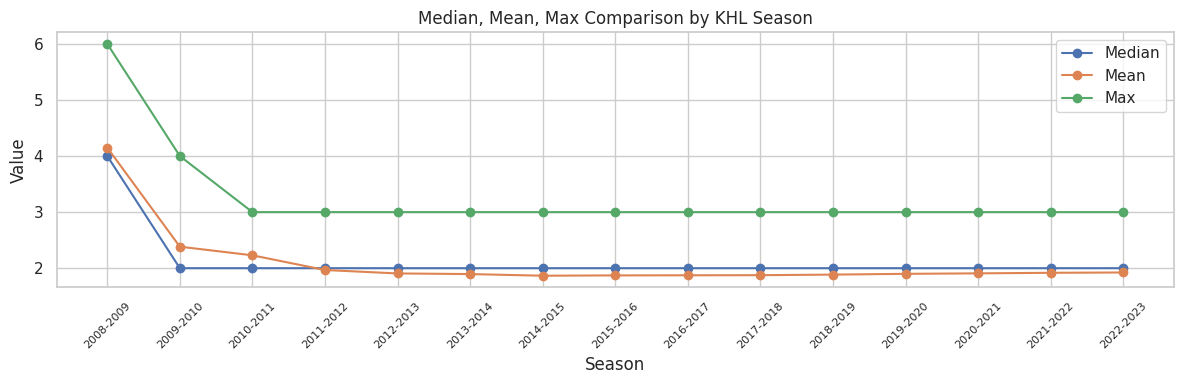

In [206]:
plt.figure(figsize=(12, 4))
plt.plot(lemtyugov_by_season['key'], lemtyugov_by_season['median'], marker='o', label='Median')
plt.plot(lemtyugov_by_season['key'], lemtyugov_by_season['mean'], marker='o', label='Mean')
plt.plot(lemtyugov_by_season['key'], lemtyugov_by_season['max'], marker='o', label='Max')

plt.xlabel('Season')
plt.ylabel('Value')
plt.title('Median, Mean, Max Comparison by KHL Season')
plt.xticks(rotation=45)
plt.gca().tick_params(axis='x', labelsize=8)  # размер меток на оси x
plt.legend()

plt.tight_layout()
plt.show()

В первом сезоне (2008-2009) между хоккеистами было меньше связей друг с другом, поэтому видим высокие значения числа Лемтюгова. Дальше близость между хоккеистами становится всё более тесной. Максимальное число Лемтюгова только в первые два сезона превышало значение 3, которое сохраняется до последнего сезона.

In [207]:
lemt_number_values_by_season = result_df[['key',
                                          'player_id_nunique',
                                          0, 1, 2, 3, 4, 5, 6]]
lemt_number_values_by_season

key  player_id_nunique  0    1     2    3    4    5   6
0   2008-2009                774  1   27     3  116  348  235  44
1   2009-2010               1029  1   73   486  468    1    0   0
2   2010-2011               1202  1   79   765  357    0    0   0
3   2011-2012               1358  1  144  1111  102    0    0   0
4   2012-2013               1614  1  202  1358   53    0    0   0
5   2013-2014               1870  1  256  1551   62    0    0   0
6   2014-2015               2078  1  311  1732   34    0    0   0
7   2015-2016               2303  1  327  1942   33    0    0   0
8   2016-2017               2513  1  343  2142   27    0    0   0
9   2017-2018               2717  1  357  2339   20    0    0   0
10  2018-2019               2902  1  357  2517   27    0    0   0
11  2019-2020               3104  1  357  2699   47    0    0   0
12  2020-2021               3352  1  357  2944   50    0    0   0
13  2021-2022               3552  1  357  3127   67    0    0   0
14  2022-2023               3720  1  357  3287   75    0    0   0

In [208]:
# Путь к файлу на Google Drive
#file_path = '/content/drive/MyDrive/lemt_number_values_by_season.csv'

# Сохранение датафрейма в CSV-файле
#lemt_number_values_by_season.to_csv(file_path, index=False)

# Скачивание файла на локальный компьютер
#files.download(file_path)

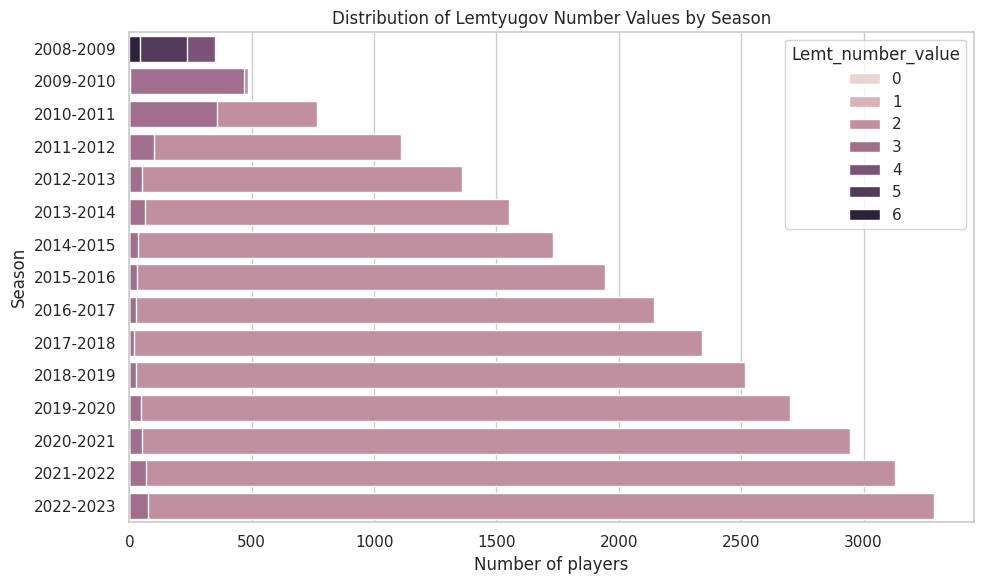

In [209]:
# Переворачиваем таблицу для удобства визуализации
melted_df = pd.melt(lemt_number_values_by_season, id_vars=['key'],
                    value_vars=[0, 1, 2, 3, 4, 5, 6],
                    var_name='Lemt_number_value',
                    value_name='Value')

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Используем горизонтальную столбчатую диаграмму для визуализации распределения значений для каждой категории внутри каждого сезона
sns.barplot(x='Value', y='key', hue='Lemt_number_value', data=melted_df, dodge=False, orient='h')

plt.xlabel('Number of players')
plt.ylabel('Season')
plt.title('Distribution of Lemtyugov Number Values by Season')

plt.tight_layout()  # Улучшает распределение элементов на графике
plt.show()

Видим, что из сезона в сезон не только растет количество игроков, бывавших в Лиге, но также и увеличивается близость хоккеистов к Лемтюгову.

Построим еще один график, на котором показажем, сколько хоккеистов было в лиге по годам, и раскрасим по значению числа Лемтюгова.

In [210]:
lemt_number_values_by_season.columns = ['season', "player_id_nunique", "lemt_0", "lemt_1", "lemt_2", "lemt_3", "lemt_4", "lemt_5", "lemt_6"]

In [211]:
fig = go.Figure()
colors = ['black', 'red', 'yellow', 'green', 'purple', 'orange', 'pink']

for i, col in enumerate(lemt_number_values_by_season.columns[2:]):
    fig.add_trace(go.Scatter(
        x=lemt_number_values_by_season["season"],
        y=lemt_number_values_by_season[col],
        fill='tonexty',  # Заливка до следующей кривой
        mode='none',
        name=col,
        stackgroup='one',  # Группа для стекирования
        hoverinfo="y+name",
        line=dict(color=f"rgba({i * 30},{i * 70},{i * 100},1)")
    ))

fig.update_layout(
    title="Количество хоккеистов по сезонам с учетом числа Лемтюгова",
    xaxis=dict(title="Сезон"),
    yaxis=dict(title="Значение числа Лемтюгова"),
    xaxis_tickangle=-45,
    legend=dict(x=0, y=1, title_text="Число Лемтюгова"),
    margin=dict(l=0, r=0, t=60, b=0),
    showlegend=True,
    hovermode="x",
    width=1000,
    height=600
)

#fig.show()

Происходит рост количества игроков, растет доля игроков с числом Лемтюгова 2.

### Визуализация графов

Далее визуализируем графы. Данные за сезон '2008-2009' находятся в словаре lemtyugov_number_dataframe['2008-2009'].

In [212]:
lemtyugov_number_dataframe['2008-2009'].head()

player_id  lemtyugov_number
0     13705                 0
1     11543                 1
2     13036                 1
3     14267                 1
4      5211                 1

In [213]:
#clubmates_dataframes_dict['2008-2009']

In [214]:
# Создаем пустой граф
G = nx.Graph()

# Добавляем узлы и ребра на основе словаря
for node, neighbors in clubmates_dataframes_dict['2008-2009'].items():
    G.add_node(node)
    G.add_edges_from((node, neighbor) for neighbor in neighbors)

In [215]:
pos = nx.spring_layout(G, seed=10) #здесь позиционирование узлов

In [216]:
#задаем позицию для каждого узла
for node in G.nodes:
    G.nodes[node]['pos'] = list(pos[node])

In [217]:
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Hot',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

In [218]:
# задаем позицию для каждого узла
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('player: '+str(adjacencies[0])+ ' ' + '# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [219]:
#выводим граф
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(width=800, height=800,
                title='Граф связей игроков за сезон 2008-2009',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

Аналогично визуализируем данные за следующий сезон.

⏰

In [220]:
#clubmates_dataframes_dict['2009-2010']

In [221]:
# Создаем пустой граф
G = nx.Graph()

# Добавляем узлы и ребра на основе словаря
for node, neighbors in clubmates_dataframes_dict['2009-2010'].items():
    G.add_node(node)
    G.add_edges_from((node, neighbor) for neighbor in neighbors)

pos = nx.spring_layout(G, seed=10) #здесь позиционирование узлов

#задаем позицию для каждого узла
for node in G.nodes:
    G.nodes[node]['pos'] = list(pos[node])

edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Hot',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

In [222]:
# задаем позицию для каждого узла
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('player: '+str(adjacencies[0])+ ' ' + '# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [223]:
#выводим граф
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(width=800, height=800,
                title= "Player Network Graph for the 2009-2010 Season",
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

## Гипотеза о связи роста/веса и количестве переходов у хоккеиста

Проверим, есть ли связь между количеством переходов и ростом/весом игрока (предполагаем, что игроки, у которых рост выше, лучше играют в хоккей и
соответственно чаще переходят из клуба в клуб).

In [224]:
players_transfers_count = players.groupby('player_id').size().reset_index(name='transfers_count').sort_values(
    by='transfers_count')

players_transfers_count

player_id  transfers_count
2095     22346                1
2093     22344                1
2092     22342                1
2091     22326                1
2090     22325                1
...        ...              ...
3605       548               12
221      14299               13
3601      5433               13
108      13679               14
3482      4351               14

[3720 rows x 2 columns]

Количество переходов у одного хоккеиста варьируется от 1 до 14.

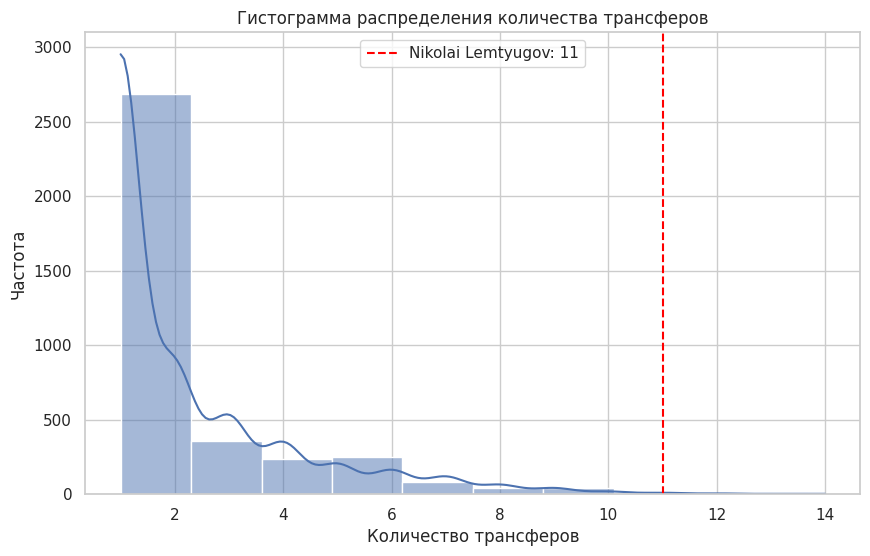

In [225]:
plt.figure(figsize=(10, 6))

sns.histplot(data=players_transfers_count,
             x='transfers_count',
             bins=10,
             kde=True)

# Особая отметка для заданного значения
special_value = players_transfers_count[players_transfers_count['player_id'] == '13705']['transfers_count'].values[0]
plt.axvline(x=special_value, color='red', linestyle='dashed', label=f'Nikolai Lemtyugov: {special_value}')
plt.legend()

plt.xlabel('Количество трансферов')
plt.ylabel('Частота')
plt.title('Гистограмма распределения количества трансферов')

plt.show()

In [226]:
find_player_id_by_name(player_dict, "Nikolai Lemtyugov")

'13705'

In [227]:
players_transfers_count[players_transfers_count['player_id']=='13705']

player_id  transfers_count
116     13705               11

In [228]:
players.groupby('player_id').size().reset_index(name='transfers_count').sort_values(by='transfers_count')

player_id  transfers_count
2095     22346                1
2093     22344                1
2092     22342                1
2091     22326                1
2090     22325                1
...        ...              ...
3605       548               12
221      14299               13
3601      5433               13
108      13679               14
3482      4351               14

[3720 rows x 2 columns]

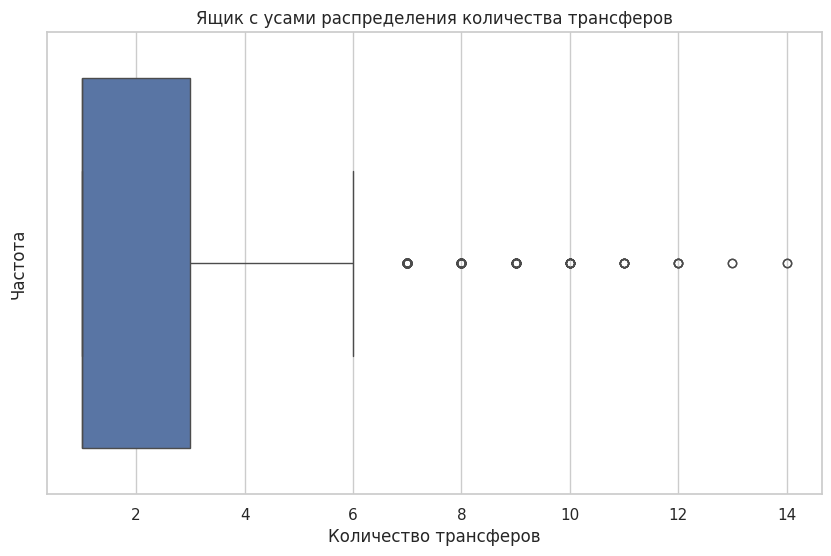

In [229]:
plt.figure(figsize=(10, 6))
transfers_count_data = players.groupby('player_id').size().reset_index(name='transfers_count').sort_values(by='transfers_count')
sns.boxplot(x='transfers_count', data=transfers_count_data)
plt.xlabel('Количество трансферов')
plt.ylabel('Частота')
plt.title('Ящик с усами распределения количества трансферов')
plt.show()

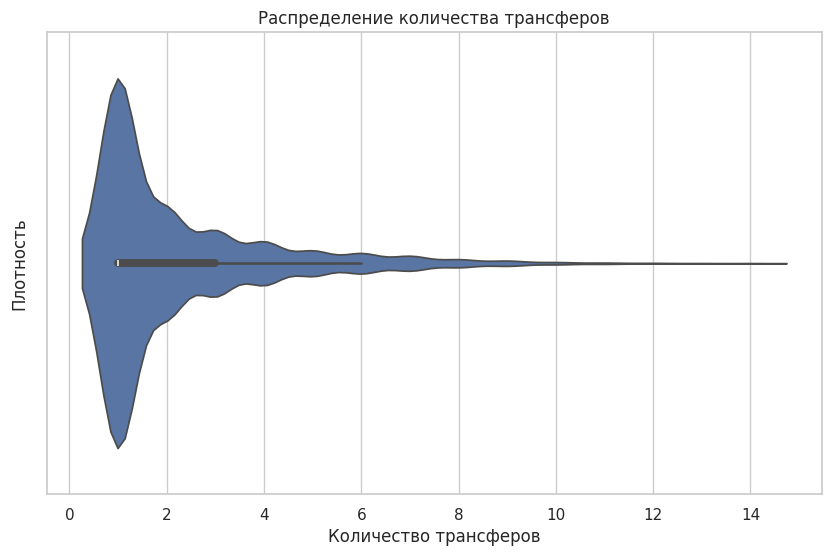

In [230]:
plt.figure(figsize=(10, 6))
transfers_count_data = players.groupby('player_id').size().reset_index(name='transfers_count').sort_values(by='transfers_count')
sns.violinplot(x='transfers_count', data=transfers_count_data)
plt.xlabel('Количество трансферов')
plt.ylabel('Плотность')
plt.title('Распределение количества трансферов')
plt.show()

Видим, что у большинства хоккеистов не так много переходов (трансферов).

Данные о росте/ весе хоккеистов лежат в датасете stat.

In [231]:
stat.head()

player_link  \
0  https://en.khl.ru/players/16785/?idplayer=16785&PAGEN_1=1   
1  https://en.khl.ru/players/17585/?idplayer=17585&PAGEN_1=1   
2  https://en.khl.ru/players/13041/?idplayer=13041&PAGEN_1=1   
3  https://en.khl.ru/players/38736/?idplayer=38736&PAGEN_1=1   
4  https://en.khl.ru/players/24998/?idplayer=24998&PAGEN_1=1   

                player    position        born age  country  hight  weight  \
0   Juhamatti Aaltonen     forward   4-июн.-85  38  Finland    184      89   
1        Miro Aaltonen     forward   7-июн.-93  30  Finland    177      84   
2  Ruslan Abdrakhmanov     forward  25-дек.-84  38   Russia    178      77   
3       Jindrich Abdul     forward  1-февр.-96  27  Czechia    185      85   
4    Ilnur Abdulkhakov  goaltender  15-янв.-99  24   Russia    187      84   

   shoot   GP  ...  TIE/G  SFTE/G  TIPP/G  SFTPP/G  TISH/G  SFTSH/G   HITS  \
0  right  245  ...  12:30      18    2:44     3,62    0:21     0,74  31.00   
1   left  256  ...  13:38   20,59    3:16     3,79    0:43      1,5 182.00   
2   left   10  ...   9:14    11,7    0:48      1,8    0:05      0,3   0.00   
3   left   12  ...  10:21   15,75    1:34     2,33    0:57     1,75   6.00   
4   left    0  ...    NaN     NaN     NaN      NaN     NaN      NaN    NaN   

     BLS   FOA  TkA  
0  17.00 22.00 0.00  
1 116.00 60.00 0.00  
2   0.00  0.00 0.00  
3   3.00  7.00 0.00  
4    NaN   NaN  NaN  

[5 rows x 41 columns]

In [232]:
stat['player_link'].nunique()

3717

In [233]:
stat["player_id"] = stat["player_link"].apply(
    lambda x: re.search(r'idplayer=(\d+)', x).group(1) if re.search(r'idplayer=(\d+)', x) else None)

In [234]:
stat['player_id'].nunique()

3717

In [235]:
del stat['player_link']

In [236]:
hight_weight_data = stat[['player_id', 'hight', 'weight']]

In [237]:
hight_weight_data

player_id  hight  weight
0        16785    184      89
1        17585    177      84
2        13041    178      77
3        38736    185      85
4        24998    187      84
...        ...    ...     ...
3712     19061    194      85
3713     16028    189      97
3714     15765    170      76
3715     16593    187      88
3716     40564    188      81

[3717 rows x 3 columns]

Объединим наши данные.

In [238]:
players_transfers_count_stats = players_transfers_count.merge(
    hight_weight_data,
    on = 'player_id')

players_transfers_count_stats

player_id  transfers_count  hight  weight
0        22346                1    190      94
1        22344                1    184      92
2        22342                1    178      87
3        22326                1    187      89
4        22325                1    193     100
...        ...              ...    ...     ...
3712       548               12    193      91
3713     14299               13    189      96
3714      5433               13    175      81
3715     13679               14    190      94
3716      4351               14    192     100

[3717 rows x 4 columns]

In [239]:
# Путь к файлу на Google Drive
#file_path = '/content/drive/MyDrive/players_transfers_count_stats.csv'

# Сохранение датафрейма в CSV-файле
#players_transfers_count_stats.to_csv(file_path, index=False)

# Скачивание файла на локальный компьютер
#files.download(file_path)

In [240]:
players_transfers_count_stats[players_transfers_count_stats['player_id'] == '13705']

player_id  transfers_count  hight  weight
3705     13705               11    184      96

Посмотрим на распределения роста и веса хоккеистов.

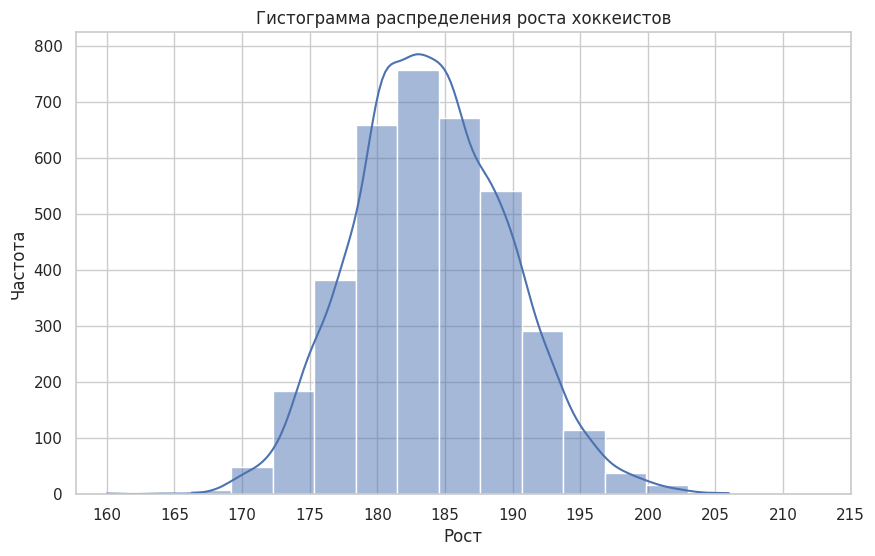

In [241]:
plt.figure(figsize=(10, 6))
sns.histplot(data=players_transfers_count_stats,
             x='hight',
             bins=15,
             kde=True)
plt.xlabel('Рост')
plt.ylabel('Частота')
plt.title('Гистограмма распределения роста хоккеистов')
plt.xticks(range(160, 220, 5), rotation=0)
plt.show()

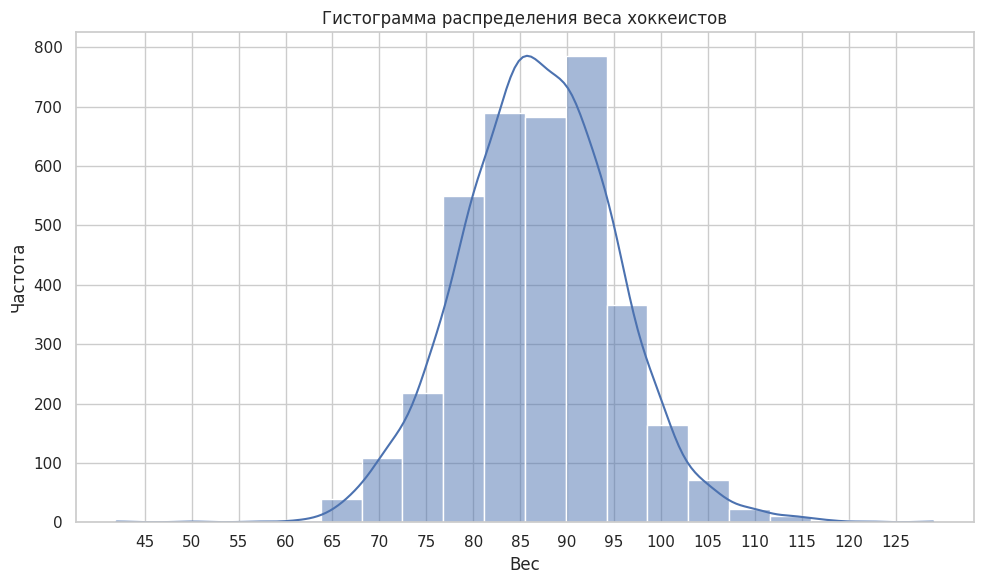

In [242]:
plt.figure(figsize=(10, 6))
sns.histplot(data=players_transfers_count_stats,
             x='weight',
             bins=20,
             kde=True)
plt.title('Гистограмма распределения веса хоккеистов')
plt.xlabel('Вес')
plt.ylabel('Частота')
plt.xticks(range(45, 130, 5), rotation=0)
plt.tight_layout()
plt.show()

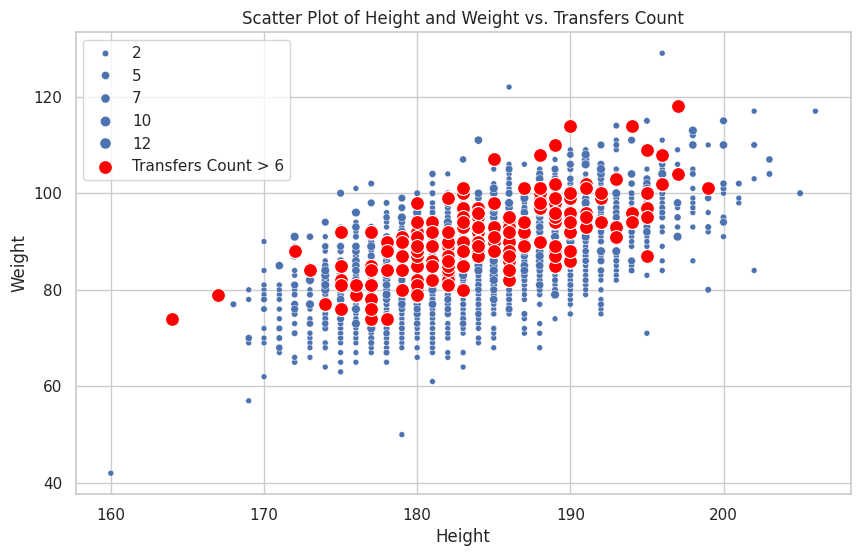

In [243]:
plt.figure(figsize=(10, 6))

# Создание scatter plot
sns.scatterplot(x='hight',
                y='weight',
                size='transfers_count',
                data=players_transfers_count_stats)

# Отметка точек с transfers_count > 6 красным цветом
sns.scatterplot(x='hight',
                y='weight',
                data=players_transfers_count_stats[players_transfers_count_stats['transfers_count'] > 6],
                color='red',
                s=100,  # Размер красных точек
                label='Transfers Count > 6')

plt.title('Scatter Plot of Height and Weight vs. Transfers Count')
plt.xlabel('Height')
plt.ylabel('Weight')
plt.legend()

plt.show()

**Нулевая гипотеза (H0):** Между ростом хоккеистов и количеством их трансферов не существует статистически значимой корреляции.

**Альтернативная гипотеза (H1):** Существует статистически значимая корреляция между ростом хоккеистов и количеством их трансферов.

In [244]:
# Данные
hight = players_transfers_count_stats['hight']
transfers_count = players_transfers_count_stats['transfers_count']

# Вычисляем коэффициент корреляции Спирмена и p-значение
corr, p_value = stats.spearmanr(hight, transfers_count)

# Уровень значимости (alpha)
alpha = 0.05

# Определяем критическое значение для уровня значимости и количества наблюдений
critical_value = stats.t.ppf(1 - alpha, len(hight) - 2)

# Определяем границы для области отвержения нулевой гипотезы
lower_bound = -critical_value
upper_bound = critical_value

# Выводим результаты
print(f"Коэффициент корреляции Спирмена: {corr:.4f}")
print(f"P-значение: {p_value:.4f}")

if p_value < alpha:
    print("Отвергаем нулевую гипотезу: есть статистически значимая корреляция")
    if corr < lower_bound:
        print("Ошибка первого рода: положительная корреляция, но отвергли")
    elif corr > upper_bound:
        print("Ошибка первого рода: отрицательная корреляция, но отвергли")
else:
    print("Не отвергаем нулевую гипотезу: нет статистически значимой корреляции")
    if lower_bound < corr < upper_bound:
        print("Ошибка второго рода: не отвергли нулевую гипотезу, хотя есть корреляция")


Коэффициент корреляции Спирмена: 0.0356
P-значение: 0.0301
Отвергаем нулевую гипотезу: есть статистически значимая корреляция


**Нулевая гипотеза (H0):** Между весом хоккеистов и количеством их трансферов не существует статистически значимой корреляции.

**Альтернативная гипотеза (H1):** Существует статистически значимая корреляция между весом хоккеистов и количеством их трансферов.

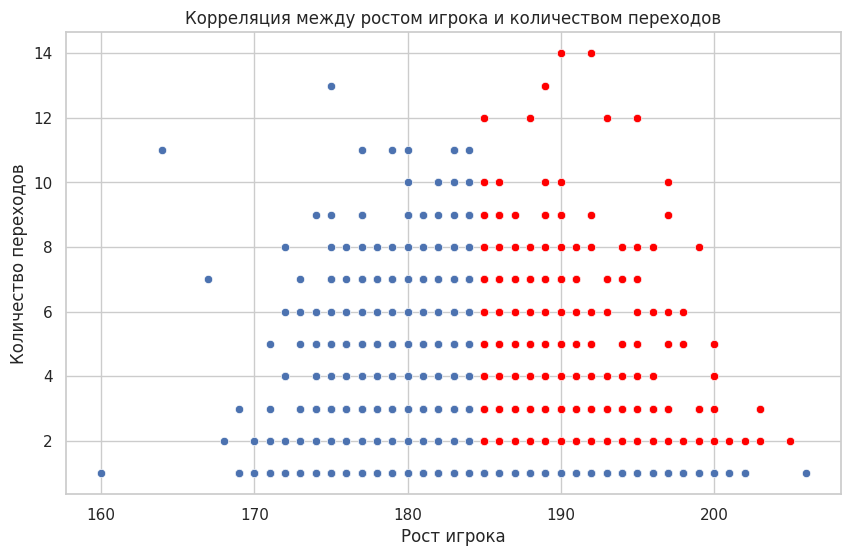

In [245]:
plt.figure(figsize=(10, 6))

# Разделяем данные на две категории: большой рост и большое количество переходов
high_weight_high_transfers = players_transfers_count_stats[
    (players_transfers_count_stats['hight'] > players_transfers_count_stats['hight'].median()) &
    (players_transfers_count_stats['transfers_count'] > players_transfers_count_stats['transfers_count'].median())
]

# Создаем scatter plot с обычными точками
sns.scatterplot(x='hight', y='transfers_count', data=players_transfers_count_stats)

# Создаем scatter plot с красными точками для игроков с большим ростом и большим количеством переходов
sns.scatterplot(x='hight', y='transfers_count', data=high_weight_high_transfers, color='red')

# Добавляем название графика и метки осей
plt.title("Корреляция между ростом игрока и количеством переходов")
plt.xlabel("Рост игрока")
plt.ylabel("Количество переходов")

# Отображаем график
plt.show()

In [246]:
# Данные
hight = players_transfers_count_stats['weight']
transfers_count = players_transfers_count_stats['transfers_count']

# Вычисляем коэффициент корреляции Спирмена и p-значение
corr, p_value = stats.spearmanr(hight, transfers_count)

# Уровень значимости (alpha)
alpha = 0.05

# Определяем критическое значение для уровня значимости и количества наблюдений
critical_value = stats.t.ppf(1 - alpha, len(hight) - 2)

# Определяем границы для области отвержения нулевой гипотезы
lower_bound = -critical_value
upper_bound = critical_value

# Выводим результаты
print(f"Коэффициент корреляции Спирмена: {corr:.4f}")
print(f"P-значение: {p_value:.4f}")

if p_value < alpha:
    print("Отвергаем нулевую гипотезу: есть статистически значимая корреляция")
    if corr < lower_bound:
        print("Ошибка первого рода: положительная корреляция, но отвергли")
    elif corr > upper_bound:
        print("Ошибка первого рода: отрицательная корреляция, но отвергли")
else:
    print("Не отвергаем нулевую гипотезу: нет статистически значимой корреляции")
    if lower_bound < corr < upper_bound:
        print("Ошибка второго рода: не отвергли нулевую гипотезу, хотя есть корреляция")

Коэффициент корреляции Спирмена: 0.2459
P-значение: 0.0000
Отвергаем нулевую гипотезу: есть статистически значимая корреляция


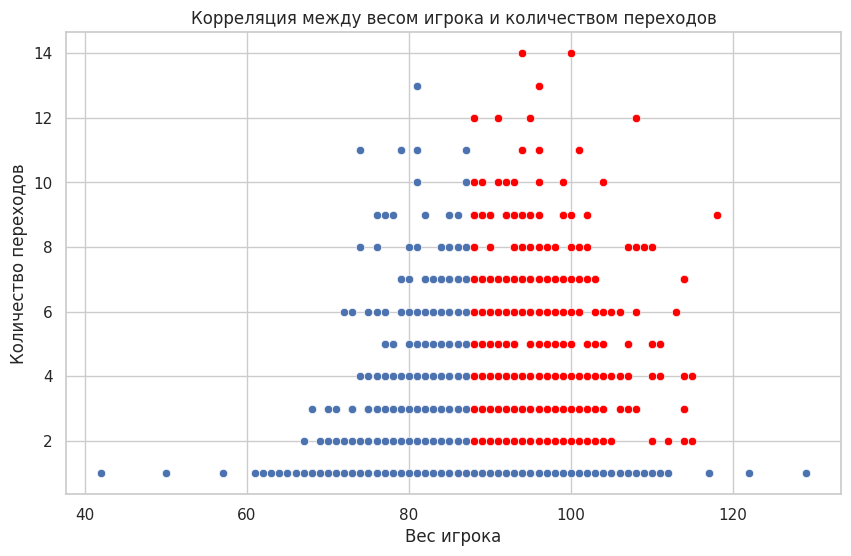

In [247]:
plt.figure(figsize=(10, 6))

# Разделяем данные на две категории: большой вес и большое количество переходов
high_weight_high_transfers = players_transfers_count_stats[
    (players_transfers_count_stats['weight'] > players_transfers_count_stats['weight'].median()) &
    (players_transfers_count_stats['transfers_count'] > players_transfers_count_stats['transfers_count'].median())
]

# Создаем scatter plot с обычными точками
sns.scatterplot(x='weight', y='transfers_count', data=players_transfers_count_stats)

# Создаем scatter plot с красными точками для игроков с большим весом и большим количеством переходов
sns.scatterplot(x='weight', y='transfers_count', data=high_weight_high_transfers, color='red')

# Добавляем название графика и метки осей
plt.title("Корреляция между весом игрока и количеством переходов")
plt.xlabel("Вес игрока")
plt.ylabel("Количество переходов")

# Отображаем график
plt.show()

Проведем также регрессионный анализ.

In [248]:
X = players_transfers_count_stats[['hight', 'weight']]
X = sm.add_constant(X)
y = players_transfers_count_stats['transfers_count']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        transfers_count   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     137.4
Date:                Wed, 30 Apr 2025   Prob (F-statistic):           2.78e-58
Time:                        18:07:49   Log-Likelihood:                -7564.0
No. Observations:                3717   AIC:                         1.513e+04
Df Residuals:                    3714   BIC:                         1.515e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.2659      1.054      5.946      0.0

Анализ множественной регрессии показывает следующее:

* R-squared: 0.069 - Это коэффициент детерминации, который указывает, какая часть изменчивости зависимой переменной (количество переходов) объяснена моделью. В данном случае, модель объясняет около 6.9% вариации.

* F-statistic: 137.4 - Это значение F-статистики, которое проверяет гипотезу о том, что все коэффициенты регрессии равны нулю. Низкое p-значение (2.78e-58) указывает на то, что модель статистически значима.

* P>|t| для hight и weight: Они равны 0.000, что говорит о том, что и рост, и вес являются статистически значимыми предикторами количества переходов.

Коэффициенты:

* const (константа): 6.2659
* hight (рост): -0.0582
* weight (вес): 0.0765
* Интерпретация коэффициентов:

Константа (const) - базовое значение количества переходов при нулевых значениях роста и веса.
Коэффициент для роста (hight) - каждый дополнительный сантиметр роста связан с уменьшением количества переходов на 0.0582.
Коэффициент для веса (weight) - каждый дополнительный килограмм веса связан с увеличением количества переходов на 0.0765.
Эти результаты говорят о том, что существует статистически значимая, но относительно слабая связь между ростом, весом и количеством переходов. При этом, коэффициент детерминации (R-squared) низок, что означает, что другие факторы могут также влиять на количество переходов и не учтены в данной модели.

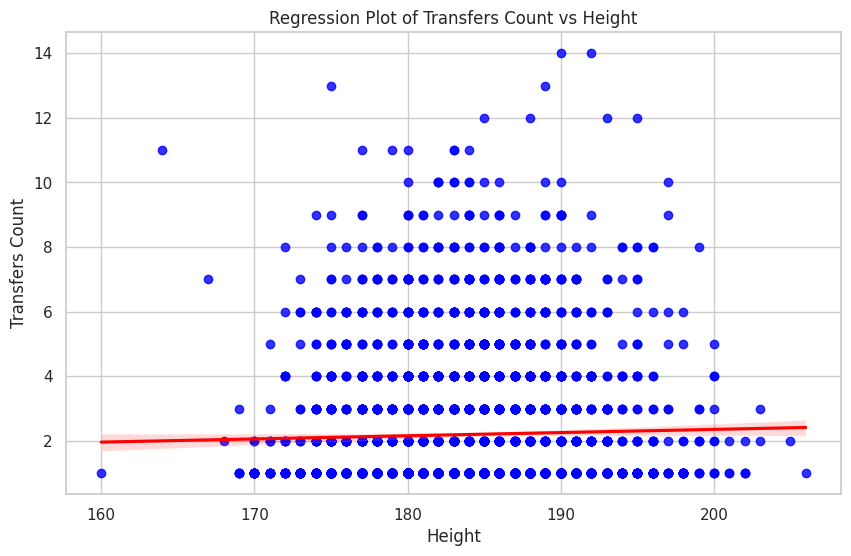

In [249]:
plt.figure(figsize=(10, 6))
sns.regplot(x='hight', y='transfers_count', data=players_transfers_count_stats, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.title('Regression Plot of Transfers Count vs Height')
plt.xlabel('Height')
plt.ylabel('Transfers Count')
plt.show()

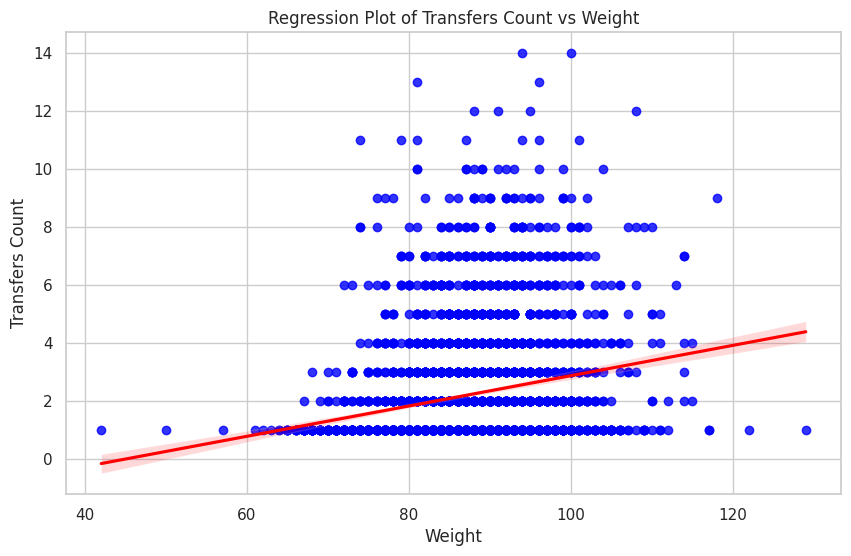

In [250]:
plt.figure(figsize=(10, 6))
sns.regplot(x='weight', y='transfers_count', data=players_transfers_count_stats, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})

plt.title('Regression Plot of Transfers Count vs Weight')
plt.xlabel('Weight')
plt.ylabel('Transfers Count')

plt.show()

Эти графики демонстрируют линию регрессии (красную линию), которая показывает тенденцию в изменении количества переходов в зависимости от роста и веса игроков. Точки на графике представляют наблюдаемые данные. Также мы могли заметить, что вес влияет на количество переходов сильнее, чем рост.

# Research Conclusions

Итак, в данном проекте было рассчитано число Лемтюгова - это своего рода **аналог "шести рукопожатий"** в мире хоккея, которое измеряет степень связи между хоккеистами в лиге КХЛ через команды, в которых они играли вместе с Николаем Лемтюговым. В контексте хоккея, число Лемтюгова помогает понять, как игроки взаимодействовали между собой. Также показывает разнообразие и глубину карьерных связей каждого хоккеиста: выборы клубов, переходы и другие аспекты карьеры хоккеиста. Тренеры и менеджеры команд могут использовать концепцию числа Лемтюгова, чтобы понять, насколько игроки могут адаптироваться к новой команде или какова вероятность успешного взаимодействия внутри коллектива.

**Результаты расчета.** По состоянию на 2023 г., хоккеисты лиги КХЛ знакомы друг с другом максимум через 3 рукопожатия. Это означает, что два случайных хоккеиста в лиге КХЛ могут быть связаны цепочкой общих команд через других хоккеистов. Даже если они никогда не играли в одной команде с Лемтюговым. Такие метрики помогают наглядно представить, насколько сильно переплетено хоккейное сообщество и как близки могут быть взаимоотношения между игроками.

**Медианное значение числа Лемтюгова.** Медианное значение числа Лемтюгова  равно 2. Это означает, что большинство хоккеистов в КХЛ связаны с Николаем Лемтюговым через других игроков и команды всего через 2 рукопожатия. Этот результат подчеркивает относительную близость и связанность игроков в хоккейной среде.

**Эволюция социальной сети хоккеистов КХЛ.** Рассчитали число Лемтюгова по сезонам с начала существования КХЛ. В первом сезоне (2008-2009) между хоккеистами было меньше связей друг с другом, поэтому видим высокие значения числа Лемтюгова. Это можно объяснить тем, что на старте лиги КХЛ у игроков было меньше возможностей играть вместе, что приводило к более длинным цепочкам связей через других игроков.  По мере развития лиги и увеличения числа сезонов связи между хоккеистами становились более тесными, что отражается в снижении значения числа Лемтюгова. Важно, что максимальное число Лемтюгова начинает превышать 3 только в первые 2 сезона. Затем остается на уровне 3 — игроки в целом становились все ближе друг к другу в течение последующих сезонов. Это наблюдение подчеркивает, как социальные и карьерные связи между хоккеистами могли эволюционировать и укрепляться в течение истории лиги КХЛ.

**Гипотезы**

Мы проверили некоторые гипотезы в проекте, чтобы исследовать различные аспекты в мире хоккея.

* **Количество одноклубников.** Мы предположили, что Николай Лемтюгов — популярный хоккеист с самым большим количеством одноклубников в лиге КХЛ. Количество его одноклубников составляет 357 человек. Но есть другие хоккеисты, у которых 475 одноклубников.Таким образом, гипотеза оказалась неверной. Исследование показало, что Лемтюгов имеет большое количество связей через команды, в которых он играл. Но он не обладает максимальным количеством одноклубников в лиге КХЛ. Это наблюдение подчеркивает сложность и разнообразие взаимосвязей в мире хоккея. Подобные анализы помогают лучше понять структуру хоккейных сообществ, связи между игроками и влияние игроков на командную динамику.

*  **Количество команд.** Близость к Николаю Лемтюгову может влиять на количество команд, в которых игроки сыграют, и на их сеть контактов. Это может иметь долгосрочные последствия, как для индивидуальной карьеры игрока, так и для динамики хоккейного сообщества в целом. Хоккеисты, имеющие более низкое значение числа Лемтюгова (т.е. более близкие к Лемтюгову в сети взаимосвязей), склонны играть в большем количестве команд и, соответственно, имеют более широкие круги контактов в хоккейной среде. Возможность менять команды и выбирать более привлекательные возможности - это отличный буст для карьеры хоккеиста, ведь, как отмечают Ведомости, за сильных игроков ведут борьбу различные хоккейные клубы и лиги. Проведенное исследование позволило обнаружить статистически значимые различия между средними значениями количества команд, в которых играли хоккеисты, в зависимости от значения числа Лемтюгова.

*  **Все связаны друг с другом.** Мы предполагали, что есть хоккеисты, которые не связаны с Лемтюговым. Это ошибочно, потому что все игроки лиги КХЛ имеют какие-либо связи через других игроков (то есть через команды, в которых они играли). Число Лемтюгова присутствует у всех игроков в выборке.

*  **Связь между ростом/весом хоккеистов и количеством их трансферов.** Физическая подготовка влияет на скорость, выносливость, силу и маневренность игроков на льду. Рост и вес могут влиять на способность хоккеиста выполнять маневры, вести шайбу и совершать броски. Результаты статистического исследования подтвердили, что существует значимая взаимосвязь между исследуемыми физическими характеристиками игроков и частотой их переходов.  Коэффициент корреляции для роста был относительно невысок (0.03). Это говорит о слабой связи между ростом хоккеистов и частотой переходов. Однако, он был статистически значим: даже слабая корреляция может быть интерпретирована как свидетельство наличия взаимосвязи. Коэффициент корреляции для веса был значительно выше (0.24). Это указывает на сильную связь между весом игроков и частотой их трансферов. Высокое p-значение говорит о том, что вероятность случайной корреляции практически нулевая, подтверждая статистическую значимость. Количество переходов связано с интересом со стороны различных клубов. Таким образом, существуют связи между ростом/весом хоккеистов и количеством их трансферов. Такие результаты можно объяснить следующим образом: рост и вес игроков влияют на количество переходов. Это объясняем тем, что хорошие физические данные повышают игровую производительность. Более высокий рост и вес дает преимущества в некоторых аспектах игры — силовые схватки, защита и атака.

*  **Жители северных городов - более успешные хоккеисты?** Мы предположили, что есть связь между местом рождения игрока и его успехами. Для проведения анализа разделили всех хоккеистов лиги КХЛ на две группы: рожденных в северных городах и в других городах. Решили, что широта в 50 будет границей определения “северности” города. За критерии успеха взяли PTS (общее количество очков), G (количество голов), Assists (количество голевых передач) и вывели интегральный показатель успеха. Оказалось, что средние показатели успешности в северных и не северных городах не имеют статистически значимых отличий.